# 0.0 - Imports

In [1]:
# Bibliotecas
import inflection
import numpy      as np
import pandas     as pd
import seaborn    as sns
import umap.umap_ as umap

from IPython.display     import HTML, Image
from matplotlib          import pyplot as plt
from pandas_profiling    import ProfileReport
from plotly              import express
from sklearn             import cluster, metrics, preprocessing, decomposition, manifold, ensemble, mixture, neighbors
from scipy.cluster       import hierarchy 
from scipy.stats         import kstest, norm
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1 - Helper Functions

In [2]:
snakecase = lambda x: inflection.underscore(x)

# Configurações de Layout
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = (24,9)
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container {width:90% ! important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\users\xcell\repositorio\projects\project_clustering_customers\.clustering\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 - Carregamento dos dados

In [3]:
# Carregar os dados para análise.
df = pd.read_csv('../data/raw/Ecommerce.csv', encoding = 'unicode_escape').drop(columns=['Unnamed: 8'])

# 1.0 - Descrição dos Dados

In [4]:
df1 = df.copy()

## 1.1 - Atributos

**InvoiceNo:** Número que identifica a transação da compra.

**StockCode:** Código do produto.

**Description:** Descrição do produto.

**Quantify:** Quantidade comprada do produto.

**InvoiceDate:** Data em que a transação foi efetuada.

**UnitPrice:** Preço unitário do produto comprado.

**CustomerID:** Número que identifica o cliente.

**Country:** País em que o cliente realizou a transação.

## 1.2 - Dimensão dos Dados

In [5]:
rows = df1.shape[0]
columns = df1.shape[1]

print(f'Número de Linhas: {rows}.')
print(f'Número de Colunas: {columns}')

Número de Linhas: 541909.
Número de Colunas: 8


## 1.3 - Renomear Nome das Colunas

In [6]:
# Renomear Lista
lista = df1.columns.tolist()

# Nome das novas colunas
new_columns = [snakecase(x) for x in lista]

# renomear as colunas
df1.columns = new_columns

## 1.4 - Check NA

In [7]:
# Verificação e existem dados nulos
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 - FillOut NA

In [8]:
# ---------------- Separação dos dados faltantes e não faltantes.

# Dados com o customer_id nulo
df_missing  = df1[df1['customer_id'].isna()].copy()

# Dados com o custome_id preenchido
df_not_missing = df1[~df1['customer_id'].isna()].copy()

In [9]:
# --------------- Verificação dos dados que podem coincidir nos dois conjuntos -----------------------

# Listando os invoice_no dos customers na
list_missing_invoice = df_missing['invoice_no'].unique().tolist()

# Verificação
df_not_missing[df_not_missing['customer_id'].isin(list_missing_invoice)]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


In [11]:
# --------------- Preenchimento dos Dados ----------------------------   

# Armazenamento dos invoice_no dos customers nulos.
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())

# Criação dos Customers Id
df_backup['customer_id'] = np.arange(19000, 19000 + len(df_backup), 1)

# Merge do Backup com o dataframe original
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left').copy()

# Junção das colunas customer id em uma única.
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# remoção das colunas customer_id_x e customer_id_y
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'])

# Verificação da Remoção dos NA's da coluna Customer.
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 - Natureza das Variáveis

In [12]:
# Verificando a tipagem dos dados.
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

## 1.7 - Limpeza dos Dados

In [13]:
# Nome dos paíse em tamanho minúsculo.
df1['country'] = df1['country'].apply(lambda x: x.lower())

## 1.8 - Mudança de Variáveis

In [14]:
# Mudança de tipagem do invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].apply(lambda x: int(x))

In [15]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.9 - Estatística Descritiva 

### 1.9.1 - Atributos Numéricos

In [16]:
# Separando somente os dados numéricos
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# ------------ Tendências Centrais ---------------------------------

# Média
mean = pd.DataFrame(num_attributes.apply(np.mean)).T

# Mediana
median = pd.DataFrame(num_attributes.apply(np.median)).T

# ---------- Tendências de Dispersão -------------------------------

# Máximo
maximo = pd.DataFrame(num_attributes.apply(np.max)).T

# Mínimo
minimo = pd.DataFrame(num_attributes.apply(np.min)).T

# Intervalo(Range)
intervalo = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T

# Desvio Padrão
desvio = pd.DataFrame(num_attributes.apply(np.std)).T

# Skewness
skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T

# Kurtosis
kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# ---------------------- Construção da Tabela de Estatística Descritiva -------------------------------

# Concatenação das Tabela
tabela_descritiva = pd.concat([minimo, maximo, intervalo, mean, median, desvio, skew, kurtosis]).T.reset_index()
tabela_descritiva.columns = ['atributos', 'minimo', 'maximo', 'intervalo', 'media', 
                             'mediana', 'desvio_padrao', 'skewness', 'kurtosis']

# Exibição da tabela descritiva
tabela_descritiva

,atributos,minimo,maximo,intervalo,media,mediana,desvio_padrao,skewness,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### Investigação dos Atributos Numéricos

**1.** Quantidade de produtos negativo: Devolução ou Pedido Cancelado?

**2.** Preço unitário igual a zero: Promoção ou Brinde?

### 1.9.2 - Atributos Categóricos

In [17]:
#Separação das Variáveis Categóricas
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
cat_attributes.columns

Index(['invoice_no', 'stock_code', 'description', 'country'], dtype='object')

#### Invoice No

In [18]:
# Exploração da variável invoice_no 
df_invoice =  df1.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x)))]

# ------- Verificação de quantidades negativas de invoice no com letras

# quantidade de dados do df_invoice
print('Quantidade de dados com Invoice_No com a letra C no início: {}'.format(len(df_invoice)))

# Quantidade de quantity negativos no df_invoice
print('Quantidade de dados com o quantity negativo: {}.'.format(len(df_invoice[df_invoice['quantity'] < 0])))

# exibição dos dados
df_invoice.head()

Quantidade de dados com Invoice_No com a letra C no início: 9291
Quantidade de dados com o quantity negativo: 9288.


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2016-11-29,27.50,united kingdom,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,united kingdom,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,united kingdom,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,united kingdom,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,united kingdom,17548


#### StockCode

In [19]:
# Exploração da variável stock_code
df_stock_code =  df1.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x)))]

# Exibição
print(df_stock_code['stock_code'].unique().tolist())
df_stock_code.head()

['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
45,536370,POST,POSTAGE,3,2016-11-29,18.00,france,12583
141,C536379,D,Discount,-1,2016-11-29,27.50,united kingdom,14527
386,536403,POST,POSTAGE,1,2016-11-29,15.00,netherlands,12791
1123,536527,POST,POSTAGE,1,2016-11-29,18.00,germany,12662
1814,536544,DOT,DOTCOM POSTAGE,1,2016-11-29,569.77,united kingdom,19001


- Os dados com stockCode somente como letra, em um primeiro momento, não nos traz informaçãoes de como impacta na na seleção dos insiders.
- Remoção de dados da coluna stock_code.

#### Description

In [20]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,united kingdom
1,536365,71053,WHITE METAL LANTERN,united kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,united kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,united kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,united kingdom


- remoção da description, pois ela não interfere na clusterização.

#### Country

In [21]:
# Países
cat_attributes['country'].unique()

array(['united kingdom', 'france', 'australia', 'netherlands', 'germany',
       'norway', 'eire', 'switzerland', 'spain', 'poland', 'portugal',
       'italy', 'belgium', 'lithuania', 'japan', 'iceland',
       'channel islands', 'denmark', 'cyprus', 'sweden', 'austria',
       'israel', 'finland', 'bahrain', 'greece', 'hong kong', 'singapore',
       'lebanon', 'united arab emirates', 'saudi arabia',
       'czech republic', 'canada', 'unspecified', 'brazil', 'usa',
       'european community', 'malta', 'rsa'], dtype=object)

# 2.0 - Filtragem dos Dados

In [22]:
df2 = df1.copy()

In [23]:
# Filtragem unit_price
df2 = df2[df2['unit_price'] >=0.04].copy()


# --------------------- Filtragem Atributos Categóricos --------------------

# lista de códigos a serem removido
list_of_codes = df_stock_code['stock_code'].unique().tolist()

# Remoção de códigos do estoque
df2 = df2[~df2['stock_code'].isin(list_of_codes)].copy()

# Remoção da variável description
df2 = df2.drop('description', axis=1).copy()

# map
df2 = df2[~df2['country'].isin(['european community', 'unspecified'])]


# ------------------- Filtragem Atributos Numéricos ------------------------

# Armazenando os dados que foram cancelados ou devolvidos
df_devolucao = df2[df2['quantity'] < 0].copy()

# Armazenando os dados que foram faturados
df_faturamento = df2[df2['quantity'] >= 0].copy()


# ------------------ Remoção de Péssimos Clientes -------------------------

df2 = df2[~df2['customer_id'].isin([16446])].copy()

# 3.0 - Feature Engineering

In [24]:
df3 = df2.copy()

## 3.1 - Criação das Features


In [25]:
# Dataframe Referência
df_ref = df_faturamento.drop(['invoice_no', 'stock_code', 'quantity', 
                   'invoice_date','unit_price', 'country'], axis=1).copy()

# Remover duplicidades 
df_ref = df_ref.drop_duplicates().reset_index(drop=True)

### 3.1.1 - Faturamento

In [26]:
# ------ Construção da Feature Monetary -------

df_faturamento['total_by_product'] = df_faturamento['quantity'] * df_faturamento['unit_price']

df_monetary = df_faturamento[['customer_id', 'total_by_product']].groupby('customer_id').sum().reset_index()
df_monetary = df_monetary.rename(columns = {'total_by_product' : 'faturamento'})

# Merge do df_monetary com o dataframe referência.
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

### 3.1.2 - Recência em Dias da Última Compra Realizada

In [27]:
# ------ Construção da Feature Recency ---------

df_recency = df_faturamento[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recencia_dias'] = (df_recency['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recencia_dias']].copy() 

# Merge do df_recency com o dataframe referência.
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

### 3.1.3 - Quantidade de Compras Realizadas

In [28]:
# ------ Construção da Feature Frequencily -------

df_num_purchases = df_faturamento[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_num_purchases = df_num_purchases.rename(columns={'invoice_no' : 'qtde_compras'})

# Merge do df_frequencily com o dataframe referência.
df_ref = pd.merge(df_ref, df_num_purchases, on='customer_id', how='left')

### 3.1.4 - Quantidade Total de Itens Comprados por Cliente

In [29]:
# ------ Construção da Feature Quantity -------

df_num_products_purchased = df_faturamento[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index()
df_num_products_purchased = df_num_products_purchased.rename(columns={'quantity' : 'qtde_total_itens_comprados'})

# Merge do df_frequencily com o dataframe referência.
df_ref = pd.merge(df_ref, df_num_products_purchased, on='customer_id', how='left')

### 3.1.5 - Quantidade de Tipos de Produtos Comprados

In [30]:
# ------ Construção da Feature Products Stock_code -------

df_num_types_products = df_faturamento[['customer_id', 'stock_code']].groupby('customer_id').count().reset_index()
df_num_types_products = df_num_types_products.rename(columns={'stock_code' : 'qtde_tipos_produtos_comprados'})

# Merge do df_frequencily com o dataframe referência.
df_ref = pd.merge(df_ref, df_num_types_products, on='customer_id', how='left')

### 3.1.6 - Ticket Médio

In [31]:
# ---------- Construção da Feature Average Ticket ---------------------

df_avg_ticket = df_faturamento[['customer_id', 'total_by_product']].groupby('customer_id').mean().reset_index()
df_avg_ticket = df_avg_ticket.rename(columns={'total_by_product':'ticket_medio'})
df_avg_ticket['ticket_medio'] = df_avg_ticket['ticket_medio'].apply(lambda x: round(x, 2))

# Merge do df_monetary com o dataframe referência.
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

### 3.1.7 - Taxa de Frequência de Compras Por Dia

In [32]:
df_aux = df_faturamento[['customer_id', 
                         'invoice_no', 
                         'invoice_date']].drop_duplicates().groupby('customer_id').agg(max_  = ('invoice_date', 'max'),
                                                                           min_   = ('invoice_date', 'min'),
                                                                           days_  = ('invoice_date', lambda x: ( (x.max() - x.min()).days ) + 1 ) ,
                                                                           buy_   = ('invoice_no', 'count')).reset_index()

# Cálculo da taxa de frequência de compra(compras/dia)
df_aux['frequencia_compra'] = df_aux[['days_', 'buy_']].apply(lambda x: x['buy_']/x['days_'], axis=1)

# Tomando os dados da taxa de frequência de compra e os customer_id
df_frequencily = df_aux[['customer_id', 'frequencia_compra']].copy()

# Merge
df_ref = pd.merge(df_ref, df_frequencily, on='customer_id', how='left')

### 3.1.8 - Número de Devoluções

In [33]:
# Armazenando a quantidade de devoluções por clientes.
df_number_returns = ( df_devolucao[['customer_id', 'quantity']].groupby('customer_id')
                                                               .sum()
                                                               .reset_index()
                                                               .rename(columns={'quantity':'qtde_devolucoes'}) )

# Reajustando valores.
df_number_returns['qtde_devolucoes'] = df_number_returns['qtde_devolucoes']*(-1)

# Merge do dataframe de devoluções com o dataframe de referência
df_ref = pd.merge(df_ref, df_number_returns, on='customer_id', how='left')

# Preenchendo os na's com os valor 0.
df_ref['qtde_devolucoes'] = df_ref['qtde_devolucoes'].apply(lambda x: 0 if pd.isna(x) else x)

### 3.1.9 - Quantidade Média de Itens por Cesta 

In [34]:
# armazenando e agrupando os dados para criar a feature average basket size
df_basket_size = (df_faturamento[['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                           .agg( n_purchases = ('invoice_no', 'nunique'),
                                                                                 n_products  = ('quantity', 'sum'))
                                                                           .reset_index())
                  
# Criando a feature basket size
df_basket_size['media_basket_size'] = df_basket_size['n_products']/df_basket_size['n_purchases']
            
# merge da feature basket_size com o dataframe de referência.
df_ref = pd.merge(df_ref, df_basket_size[['customer_id', 'media_basket_size']], on='customer_id', how='left')

### 3.1.10 - Quantidade Média de Itens Únicos por Cesta

In [35]:
# Armazenando e agrupando os dados necessários para criar a feature unique_basket_size
df_unique_basket_size =(df_faturamento[['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                                   .agg(n_purchases = ('invoice_no', 'nunique'),
                                                                                        n_stockcode = ('stock_code', 'nunique'))
                                                                                   .reset_index())

# Criar a feature avg_unique_basket_size
df_unique_basket_size['media_unique_basket_size'] = df_unique_basket_size['n_stockcode']/df_unique_basket_size['n_purchases']

# merge da feature avg_unique_basket_size com o dataframe de referência.
df_ref = pd.merge(df_ref, df_unique_basket_size[['customer_id', 'media_unique_basket_size']], on='customer_id', how='left')

### 3.1.11 - Periodicidade de Compras 

In [36]:
# Obtendo as datas de compras dos cliente
#df_aux = df_faturamento[['customer_id','invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[False, True])

# Coluna com a data da próxima compra
#df_aux['next_customer_id'] = df_aux['customer_id'].shift()

# Coluna com a data da próxima compra
#df_aux['previous_date'] = df_aux['invoice_date'].shift()

# Cálculo dos dias entre as compras
#df_aux['recency_days'] = (df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days 
                                       #if x['customer_id'] == x['next_customer_id'] 
                                       #else np.nan, axis=1))


#  ----------------------------- Trabalhar com os dados que não possuem na's --------------------------------------

# Armazenar os dados sem na´s no dataframe.
#df_aux_without_na = df_aux[~df_aux['recency_days'].isna()].copy()

# Dropar colunas desnecessárias
#df_aux_without_na = df_aux_without_na.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1)

# Calculando a periodicidade de compras.
#df_average_recency_days_without_na = df_aux_without_na.groupby('customer_id').mean().reset_index()


# Reajuste de valores
#df_average_recency_days_without_na = df_average_recency_days_without_na.rename(columns={'recency_days':'periodicidade_compras'})
#df_average_recency_days_without_na['periodicidade_compras'] = df_average_recency_days_without_na['periodicidade_compras'].apply(lambda x: round(x, 2))

#  ----------------------------- Trabalhar com os dados que não possuem na's --------------------------------------

# Armazenar os dados sem na´s no dataframe.
#df_aux_with_na = df_aux[df_aux['recency_days'].isna()].copy()

# O cliente que comprou uma vez somente e depois nunca mais realizou uma compra, não possui uma periodicidade de compra com a empresa.
# Dessa forma, assumiremos que a periodicidade desse cliente é 0.

# Lista de clientes que possuem uma certa periodicidade
#customer_period = df_average_recency_days_without_na['customer_id'].unique().tolist()

# Armazenar dados dos clientes que não possuem periodicidade de compra.
#df_aux_with_na = df_aux_with_na[~df_aux_with_na['customer_id'].isin(customer_period)].copy()

# Preenchendo os Na's com valor 0
#df_aux_with_na['recency_days'] = df_aux_with_na['recency_days'].apply(lambda x: 0 if pd.isnull(x) else x)

# Selecionando somente as colunas necessárias
#df_average_recency_days_with_na = df_aux_with_na[['customer_id', 'recency_days']].copy()

# Renomear colunas
#df_average_recency_days_with_na = df_average_recency_days_with_na.rename(columns={'recency_days':'periodicidade_compras'})
#df_average_recency_days_with_na['periodicidade_compras'] = df_average_recency_days_with_na['periodicidade_compras'].apply(lambda x: round(x, 2))

# Concatenação dos Dados
#df_average_recency_days = pd.concat([df_average_recency_days_with_na, df_average_recency_days_without_na], axis=0)

#df_ref = pd.merge(df_ref, df_average_recency_days, on='customer_id', how='left')
#df_ref.isna().sum()

In [37]:
# Obtendo as datas de compras dos cliente
df_aux = df_faturamento[['customer_id','invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[False, True])

# Coluna com a data da próxima compra
df_aux['next_customer_id'] = df_aux['customer_id'].shift()

# Coluna com a data da próxima compra
df_aux['previous_date'] = df_aux['invoice_date'].shift()

# Cálculo dos dias entre as compras
df_aux['recency_days'] = (df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days 
                                       if x['customer_id'] == x['next_customer_id'] 
                                       else np.nan, axis=1))


#  ----------------------------- Trabalhar com os dados que não possuem na's --------------------------------------

# Armazenar os dados sem na´s no dataframe.
df_aux_without_na = df_aux[~df_aux['recency_days'].isna()].copy()

# Dropar colunas desnecessárias
df_aux_without_na = df_aux_without_na.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1)

# Calculando a periodicidade de compras.
df_average_recency = df_aux_without_na.groupby('customer_id').mean().reset_index()


# Reajuste de valores
df_average_recency = df_average_recency.rename(columns={'recency_days':'periodicidade_compras'})
df_average_recency['periodicidade_compras'] = df_average_recency['periodicidade_compras'].apply(lambda x: round(x, 2))


df_ref = pd.merge(df_ref, df_average_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id                         0
faturamento                         0
recencia_dias                       0
qtde_compras                        0
qtde_total_itens_comprados          0
qtde_tipos_produtos_comprados       0
ticket_medio                        0
frequencia_compra                   0
qtde_devolucoes                     0
media_basket_size                   0
media_unique_basket_size            0
periodicidade_compras            2922
dtype: int64

# 4.0 - Análise Exploratória dos Dados

In [38]:
df4 = df_ref.copy()
df4 = df4.dropna()
df4.head()

,customer_id,faturamento,recencia_dias,qtde_compras,qtde_total_itens_comprados,qtde_tipos_produtos_comprados,ticket_medio,frequencia_compra,qtde_devolucoes,media_basket_size,media_unique_basket_size,periodicidade_compras
0,17850,5391.21,372,34,1733,297,18.15,17.000000,40.0,50.970588,0.617647,1.00
1,13047,3232.59,56,9,1390,171,18.90,0.028302,35.0,154.444444,11.666667,52.83
2,12583,6705.38,2,15,5028,232,28.90,0.040323,50.0,335.200000,7.600000,26.50
3,13748,948.25,95,5,439,28,33.87,0.017921,0.0,87.800000,4.800000,92.67
4,15100,876.00,333,3,80,3,292.00,0.073171,22.0,26.666667,0.333333,20.00


## 4.1 - Analise Univariada

**Objetivos:** Encontrar Clusters Coesos e Separados.
 
 Métricas:
     - Mínimo, Máximo, Range (Dispersão)
     - Média e Mediana
     - Desvio Padrão e Variância
     - Coeficiente de Variação
     - Distribuição

In [39]:
# Realizando o pandas profile para analisar os dados.
#profile = ProfileReport(df4)
#profile.to_file('analysis.html')

**Anotações para investigação:**

1. Faturamento máximo de 279138.02. Outlier natural ou Outlier por erro? Investigar. **Ok!**
2. Clientes com quantidade de compras realizadas em 206 vezes e 199 vezes. Investigar. **Ok!**
3. Quantidade de Itens comprados de um determinado cliente foi 196844. Investigar. **Ok!**
4. Clientes possui um tickete médio de 56157.50. Investigar. **Ok!** 
5. Clientes com Frequência de Compras de 17. **Ok!**


### 4.1.1 - Gross Revenue

In [40]:
df4[df4['customer_id'] == 16446]

,customer_id,faturamento,recencia_dias,qtde_compras,qtde_total_itens_comprados,qtde_tipos_produtos_comprados,ticket_medio,frequencia_compra,qtde_devolucoes,media_basket_size,media_unique_basket_size,periodicidade_compras
3263,16446,168472.5,0,2,80997,3,56157.5,0.009709,80995.0,40498.5,1.5,205.0


### 4.1.2 - Qtd Compras 

In [41]:
# Análise de Outlier do qtde_compras.
df4[df4['qtde_compras'] == 206]

,customer_id,faturamento,recencia_dias,qtde_compras,qtde_total_itens_comprados,qtde_tipos_produtos_comprados,ticket_medio,frequencia_compra,qtde_devolucoes,media_basket_size,media_unique_basket_size,periodicidade_compras
46,12748,32317.32,0,206,25511,4580,7.06,0.550802,1535.0,123.839806,8.572816,3.33


In [42]:
df3[df3['customer_id'] == 12748].sort_values('quantity', ascending=True).head(50)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
473393,C576831,22071,-244,2017-11-14,0.50,united kingdom,12748
473394,C576831,22070,-234,2017-11-14,0.50,united kingdom,12748
473392,C576831,23055,-144,2017-11-14,1.00,united kingdom,12748
473391,C576831,23056,-144,2017-11-14,1.00,united kingdom,12748
473390,C576831,23057,-144,2017-11-14,1.00,united kingdom,12748
473395,C576831,21843,-132,2017-11-14,4.00,united kingdom,12748
288593,C562188,85099B,-100,2017-08-01,1.79,united kingdom,12748
293375,C562594,85230G,-48,2017-08-05,0.29,united kingdom,12748
473389,C576831,23322,-40,2017-11-14,2.55,united kingdom,12748
124939,C546997,22052,-25,2017-03-16,0.42,united kingdom,12748


In [43]:
# Análise de Outlier do qtde_compras.
df4[df4['qtde_compras'] == 199]


,customer_id,faturamento,recencia_dias,qtde_compras,qtde_total_itens_comprados,qtde_tipos_produtos_comprados,ticket_medio,frequencia_compra,qtde_devolucoes,media_basket_size,media_unique_basket_size,periodicidade_compras
65,14911,140450.72,1,199,80263,5673,24.76,0.533512,3332.0,403.331658,8.974874,2.86


In [44]:
df3[df3['customer_id'] == 14911].sort_values('quantity', ascending=True).head(50)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
290364,C562375,22950,-288,2017-08-02,1.25,eire,14911
290363,C562375,22952,-240,2017-08-02,0.42,eire,14911
290359,C562375,23157,-240,2017-08-02,1.85,eire,14911
290366,C562375,22910,-200,2017-08-02,2.55,eire,14911
290367,C562375,22909,-192,2017-08-02,0.72,eire,14911
290365,C562375,22945,-144,2017-08-02,0.72,eire,14911
290375,C562375,22086,-120,2017-08-02,2.55,eire,14911
38451,C539576,35957,-96,2016-12-18,0.19,eire,14911
290346,C562375,23318,-96,2017-08-02,2.08,eire,14911
290361,C562375,22979,-72,2017-08-02,1.25,eire,14911


### 4.1.3 - Qtd de itens comprados

In [45]:
df4[df4['qtde_total_itens_comprados'] == 196844]

,customer_id,faturamento,recencia_dias,qtde_compras,qtde_total_itens_comprados,qtde_tipos_produtos_comprados,ticket_medio,frequencia_compra,qtde_devolucoes,media_basket_size,media_unique_basket_size,periodicidade_compras
951,14646,279138.02,1,72,196844,2060,135.5,0.20339,288.0,2733.944444,9.708333,8.02


In [46]:
df3[df3['customer_id'] == 14646].sort_values('quantity', ascending=True).head(20)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
319805,C564899,22956,-144,2017-08-29,1.85,netherlands,14646
319806,C564899,21787,-144,2017-08-29,0.65,netherlands,14646
271584,560710,22567,1,2017-07-18,1.45,netherlands,14646
295508,562789,23359,1,2017-08-07,1.95,netherlands,14646
295507,562789,23360,1,2017-08-07,1.95,netherlands,14646
232744,557328,23255,1,2017-06-18,4.15,netherlands,14646
232745,557328,23254,1,2017-06-18,4.15,netherlands,14646
232746,557328,22352,1,2017-06-18,2.55,netherlands,14646
232747,557328,21561,1,2017-06-18,2.55,netherlands,14646
232748,557328,21559,1,2017-06-18,2.55,netherlands,14646


### 4.1.4 - Ticket Médio

In [47]:
df4[df4['ticket_medio'] == 56157.50]

,customer_id,faturamento,recencia_dias,qtde_compras,qtde_total_itens_comprados,qtde_tipos_produtos_comprados,ticket_medio,frequencia_compra,qtde_devolucoes,media_basket_size,media_unique_basket_size,periodicidade_compras
3263,16446,168472.5,0,2,80997,3,56157.5,0.009709,80995.0,40498.5,1.5,205.0


### 4.1.5 - Frequência de Compras

In [48]:
df4[df4['frequencia_compra'] == 17]

,customer_id,faturamento,recencia_dias,qtde_compras,qtde_total_itens_comprados,qtde_tipos_produtos_comprados,ticket_medio,frequencia_compra,qtde_devolucoes,media_basket_size,media_unique_basket_size,periodicidade_compras
0,17850,5391.21,372,34,1733,297,18.15,17.0,40.0,50.970588,0.617647,1.0


### 4.1.6 - Devoluções

In [49]:
df4[df4['qtde_devolucoes'] == 9014]

,customer_id,faturamento,recencia_dias,qtde_compras,qtde_total_itens_comprados,qtde_tipos_produtos_comprados,ticket_medio,frequencia_compra,qtde_devolucoes,media_basket_size,media_unique_basket_size,periodicidade_compras
1186,15749,44534.3,235,3,18028,10,4453.43,0.030612,9014.0,6009.333333,1.666667,97.0


### **Ações**

- Remover o customer 16446

In [50]:
df4 = df4[df4.customer_id.isin([16446]) == False].copy()

## 4.2 - Análise Bivariada

In [51]:
#df42 = df4.drop(['customer_id'], axis=1)

#plt.figure(figsize=(20,15))
#sns.pairplot(df42);

**Anotações:**

1. As variáveis quantidade de compras, quantidade total de itens comprados e quantidade de produtos comprados, carregam a mesma informação.
2. Frequência de compras possui baixa variância.
3. Ticket Médio possui baixa variância.

## 4.3 - Estudo do Espaço 

In [52]:
df43 = df4.copy()
# Redimensionamento dos Dados

# Remover a coluna customer id
df43 = df43.drop('customer_id', axis=1)

# Modelo de redimensionamento
mm = preprocessing.MinMaxScaler()

# Redimensionamento
df43['faturamento']                   = mm.fit_transform(df43[['faturamento']]) 
df43['recencia_dias']                 = mm.fit_transform(df43[['recencia_dias']])
df43['qtde_compras']                  = mm.fit_transform(df43[['qtde_compras']])
df43['qtde_total_itens_comprados']    = mm.fit_transform(df43[['qtde_total_itens_comprados']])
df43['qtde_tipos_produtos_comprados'] = mm.fit_transform(df43[['qtde_tipos_produtos_comprados']])
df43['ticket_medio']                  = mm.fit_transform(df43[['ticket_medio']])
df43['frequencia_compra']             = mm.fit_transform(df43[['frequencia_compra']])
df43['qtde_devolucoes']               = mm.fit_transform(df43[['qtde_devolucoes']])
df43['media_basket_size']             = mm.fit_transform(df43[['media_basket_size']]) 
df43['media_unique_basket_size']      = mm.fit_transform(df43[['media_unique_basket_size']])
df43['periodicidade_compras']         = mm.fit_transform(df43[['periodicidade_compras']])


### 4.3.1 - PCA

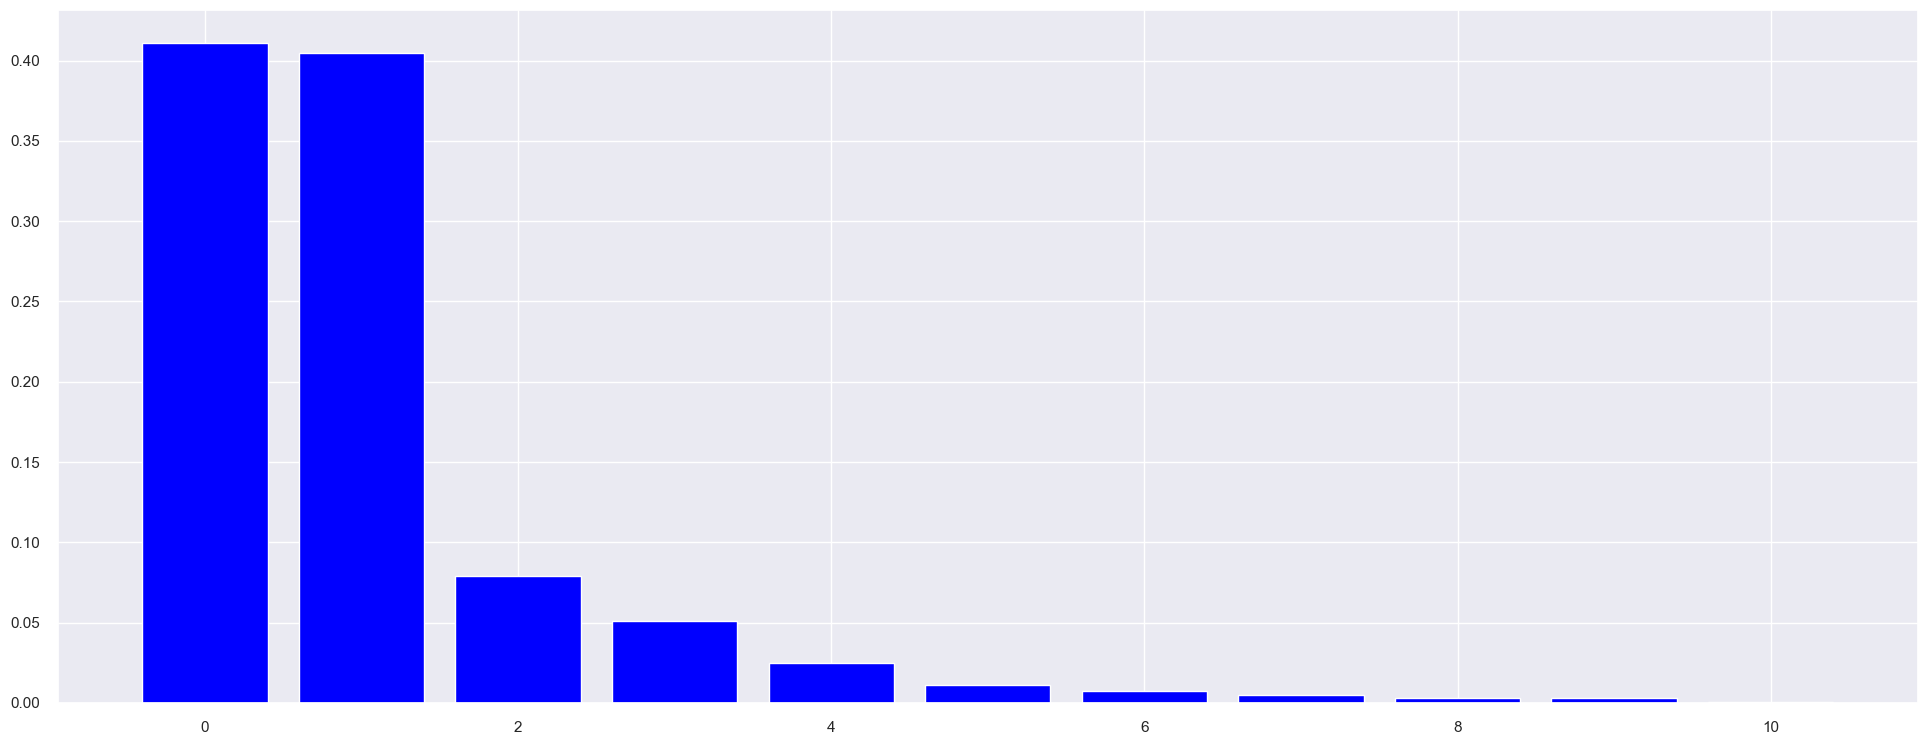

In [53]:
# Quantidade de Variáveis
n_components = df43.shape[1]

# Instanciando a classe PCA com a quantidade de VAriáveis.
pca = decomposition.PCA(n_components = n_components)

# Obtendo as componentes principais
principais_componentes = pca.fit_transform(df43)

# -------------------- Plotagem de Gráfico para verficar------------------------------------------.
features = range(pca.n_components_)

# Plotagem do Gráfico com as principais componentes.
plt.bar(features, pca.explained_variance_ratio_, color='blue');

In [54]:
df43.head()

,faturamento,recencia_dias,qtde_compras,qtde_total_itens_comprados,qtde_tipos_produtos_comprados,ticket_medio,frequencia_compra,qtde_devolucoes,media_basket_size,media_unique_basket_size,periodicidade_compras
0,0.019185,1.000000,0.156863,0.008794,0.037647,0.003594,1.000000,0.004438,0.008317,0.002362,0.000000
1,0.011451,0.150538,0.034314,0.007051,0.021567,0.003763,0.001345,0.003883,0.025539,0.064857,0.142000
2,0.023894,0.005376,0.063725,0.025533,0.029352,0.006010,0.002052,0.005547,0.055623,0.041855,0.069863
3,0.003267,0.255376,0.014706,0.002220,0.003318,0.007126,0.000734,0.000000,0.014447,0.026018,0.251151
4,0.003008,0.895161,0.004902,0.000396,0.000128,0.065116,0.003985,0.002441,0.004272,0.000754,0.052055


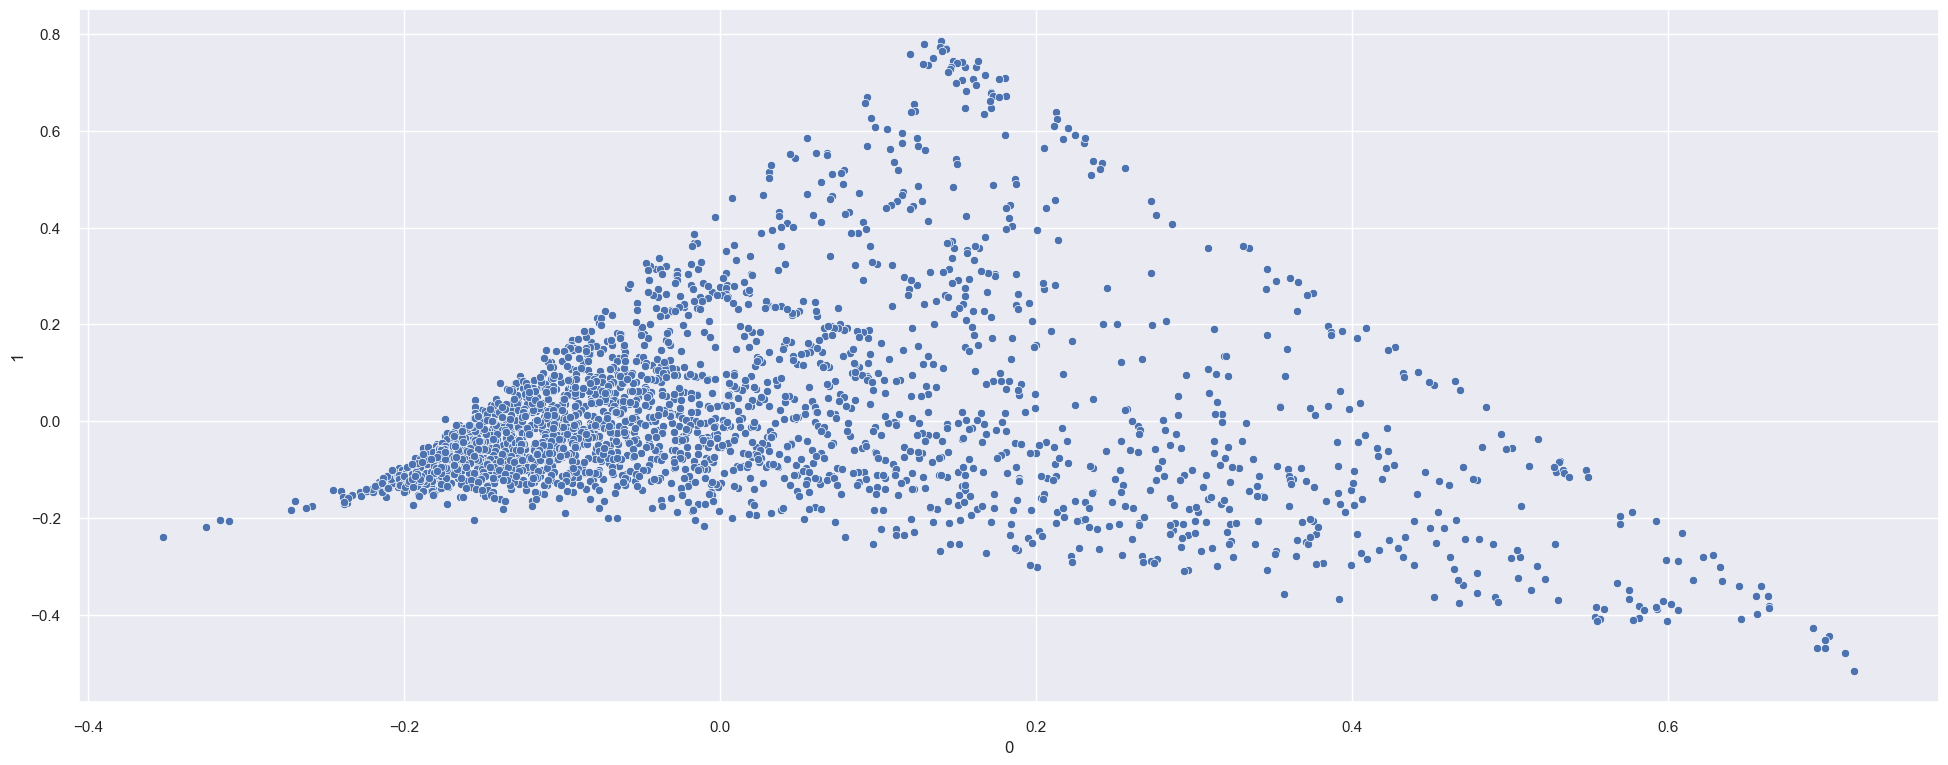

In [55]:
# --------------------- Análise das Features com Maior Variância ----------------------
# Armazenamento das principais componentes.
df_pca = pd.DataFrame(principais_componentes)

# Plotagem pra análise
sns.scatterplot(x=0, y=1, data=df_pca);

### 4.3.2 - UMAP

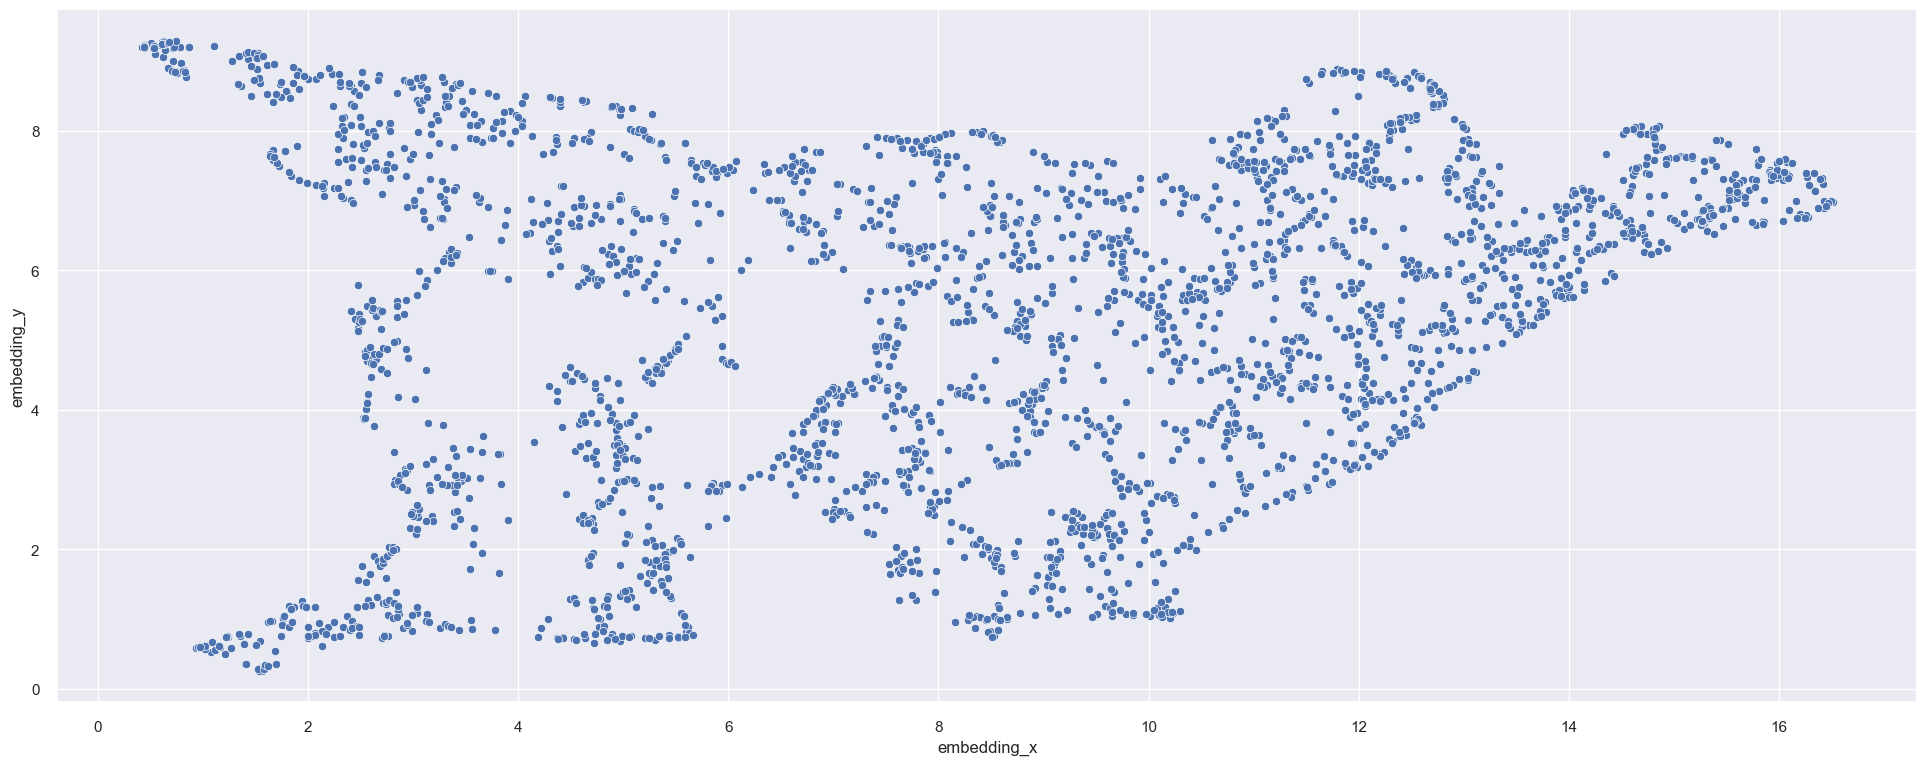

In [56]:
# Instanciando o UMAP
reducer = umap.UMAP(random_state=42)

# Realizando o mergulho
embedding = reducer.fit_transform(df43)


# Separação dos dados para plotagem.

# eixo x e y
df_pca['embedding_x'] = embedding[ : , 0]
df_pca['embedding_y'] = embedding[ : , 1] 

# Plotagem
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                data=df_pca);

### 4.3.3 - t-SNE

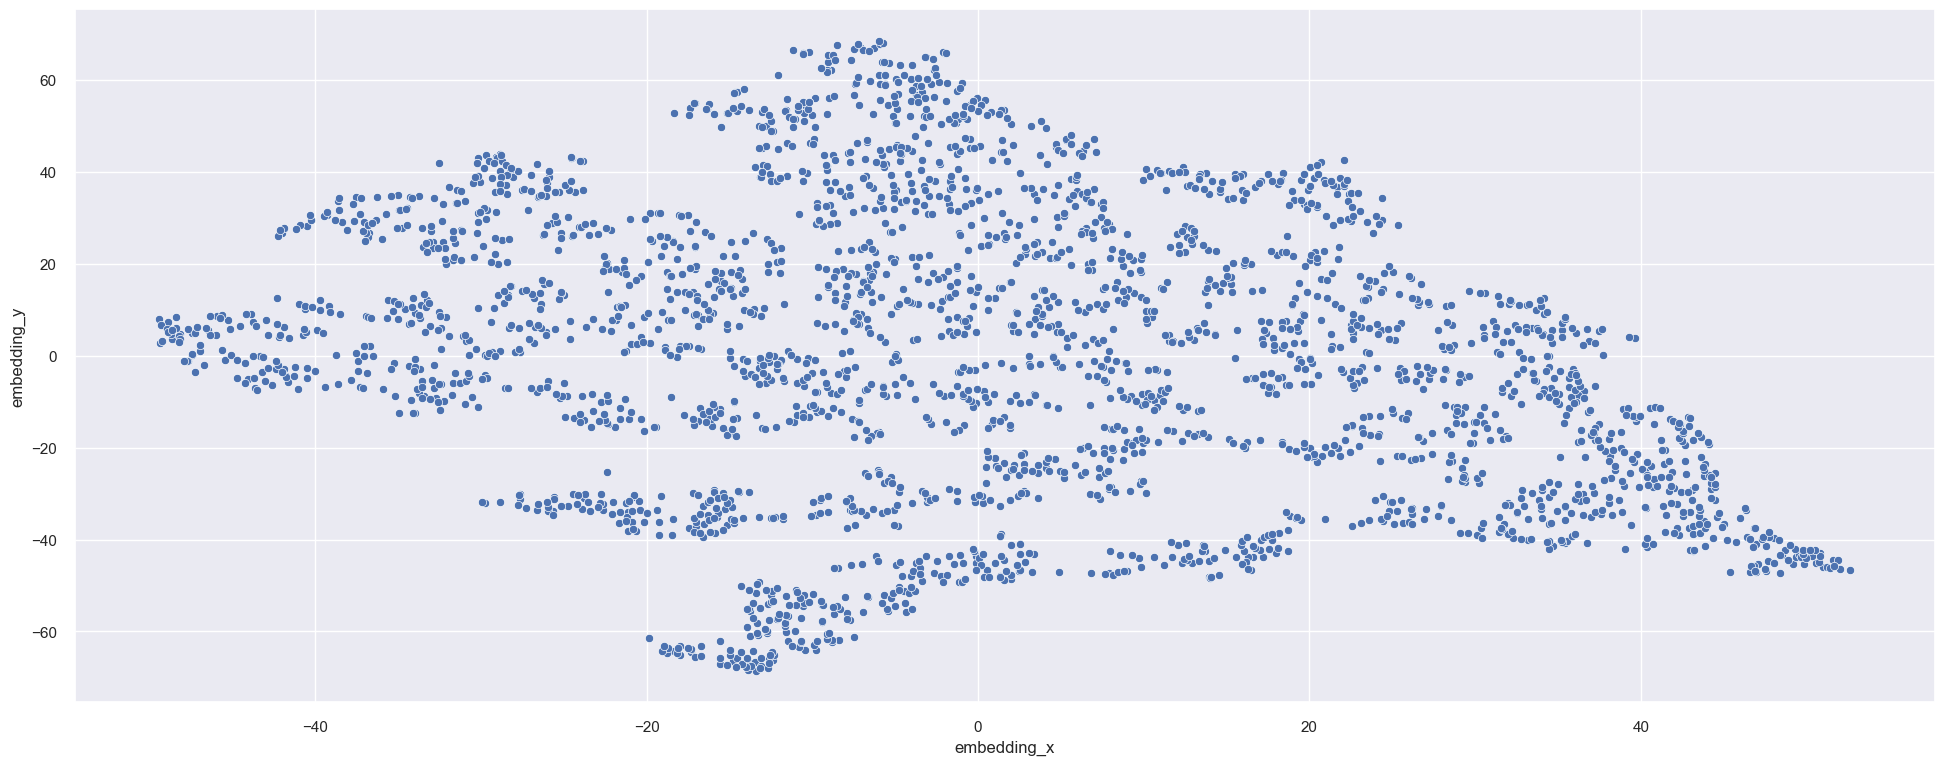

In [57]:
# Instanciando o UMAP
reducer = manifold.TSNE(n_components=2, learning_rate='auto', init='random', n_jobs=-1)

# Realizando o mergulho
embedding = reducer.fit_transform(df43)

# Separação dos dados para plotagem.
# eixo x e y
df_pca['embedding_x'] = embedding[ : , 0]
df_pca['embedding_y'] = embedding[ : , 1] 

# Plotagem
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                data=df_pca);

### 4.3.4 - Tree-Based Embedding

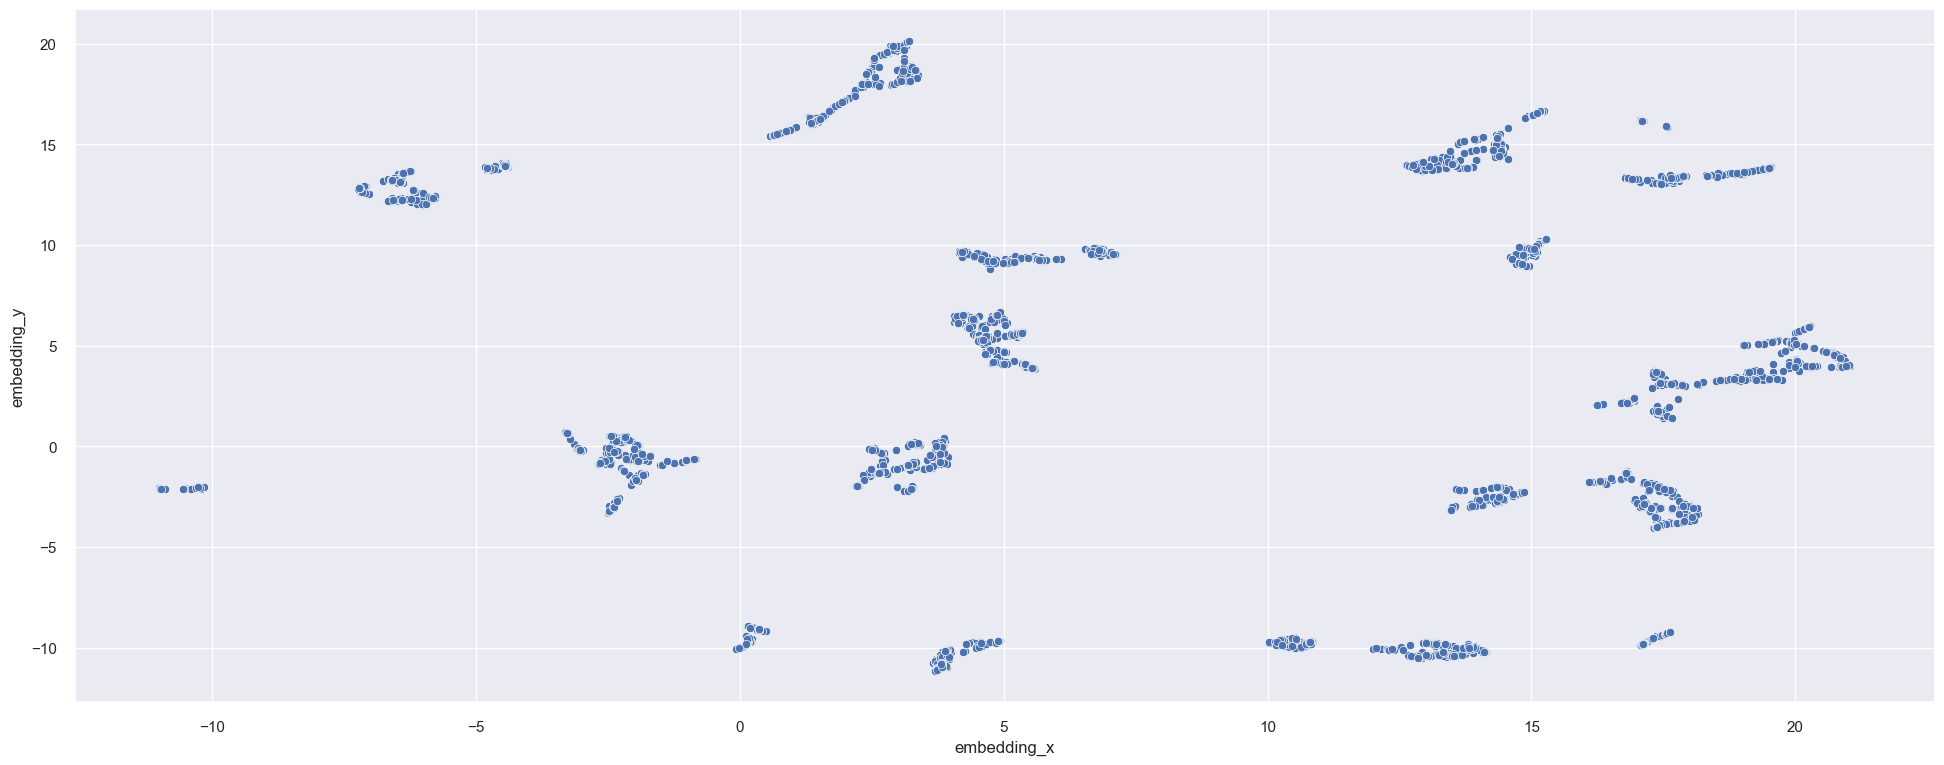

In [58]:
# Preparação dos Datasets
x_train = df43.drop('faturamento', axis=1)
y_train = df43['faturamento']

# Instanciando a RandomForest
rf_model = ensemble.RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

# Treino(Criação das árvores)
rf_model.fit(x_train, y_train)

# Armazenamento dos dados após caírem das folhas
df_leaf = pd.DataFrame(rf_model.apply(x_train))


# --------- Redução de Dimensionalidade -------------

# Instanciando o UMAP
reducer = umap.UMAP(random_state=42)

# Realizando o mergulho
embedding = reducer.fit_transform(df_leaf)


# Separação dos dados para plotagem.

# eixo x e y
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[ : , 0]
df_tree['embedding_y'] = embedding[ : , 1] 

# Plotagem
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                data=df_tree);

In [59]:
df_tree.head()

,embedding_x,embedding_y
0,7.072349,9.507873
1,4.393232,6.001794
2,2.051445,17.267487
3,13.581998,-2.162008
4,12.737460,13.940719


# 5.0 - Preparação dos Dados

In [60]:
df5 = df4.copy()

In [61]:
mm = preprocessing.MinMaxScaler()

# Padronização dos dados para input no modelo.
df5['faturamento']                   = mm.fit_transform(df5[['faturamento']])
df5['recencia_dias']                 = mm.fit_transform(df5[['recencia_dias']])
df5['qtde_compras']                  = mm.fit_transform(df5[['qtde_compras']])
df5['qtde_total_itens_comprados']    = mm.fit_transform(df5[['qtde_total_itens_comprados']])
df5['qtde_tipos_produtos_comprados'] = mm.fit_transform(df5[['qtde_tipos_produtos_comprados']])
df5['ticket_medio']                  = mm.fit_transform(df5[['ticket_medio']])
df5['frequencia_compra']             = mm.fit_transform(df5[['frequencia_compra']])
df5['qtde_devolucoes']               = mm.fit_transform(df5[['qtde_devolucoes']])
df5['media_basket_size']             = mm.fit_transform(df5[['media_basket_size']])
df5['media_unique_basket_size']      = mm.fit_transform(df5[['media_unique_basket_size']])
df5['periodicidade_compras']         = mm.fit_transform(df5[['periodicidade_compras']])

# 6.0 - Seleção das Features

In [62]:
columns_selected = ['customer_id', 
                    'faturamento', 
                    'recencia_dias',
                    'qtde_tipos_produtos_comprados', 
                    'frequencia_compra', 
                    'qtde_devolucoes']

df5 = df5[columns_selected].copy()

## 6.1 - Espaço de Embeeding com as Features Selecionadas

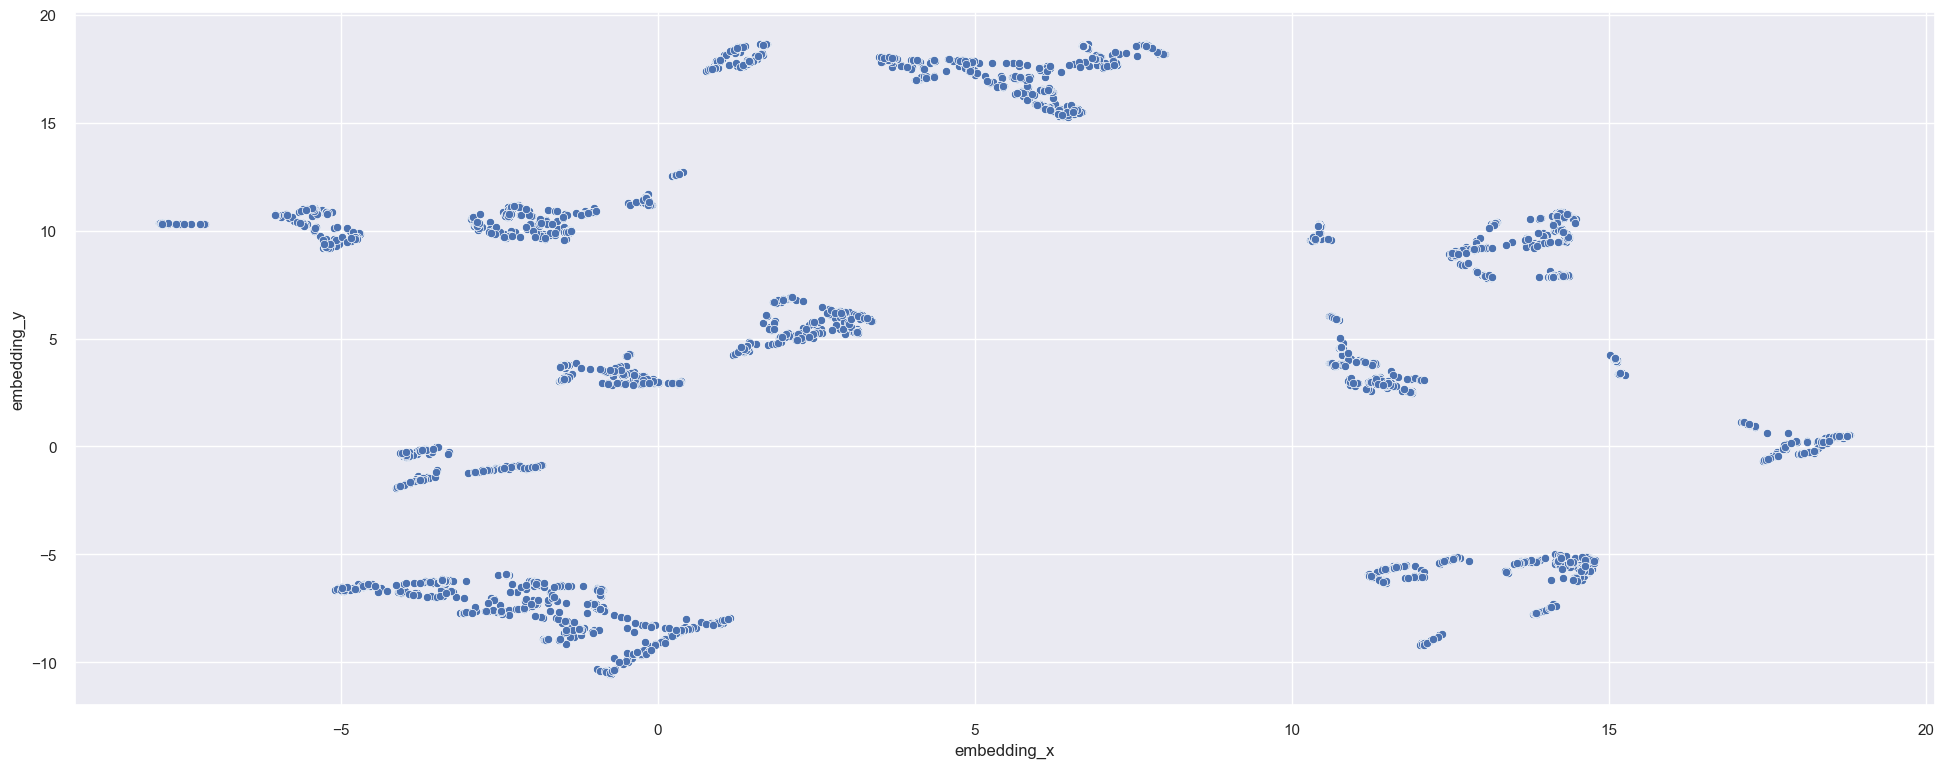

In [63]:
# Preparação dos Datasets
x_train = df5.drop('faturamento', axis=1)
y_train = df5['faturamento']

# Instanciando a RandomForest
rf_model = ensemble.RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

# Treino(Criação das árvores)
rf_model.fit(x_train, y_train)

# Armazenamento dos dados após caírem das folhas
df_leaf = pd.DataFrame(rf_model.apply(x_train))


# --------- Redução de Dimensionalidade -------------

# Instanciando o UMAP
reducer = umap.UMAP(random_state=42)

# Realizando o mergulho
embedding = reducer.fit_transform(df_leaf)


# Separação dos dados para plotagem.

# eixo x e y
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[ : , 0]
df_tree['embedding_y'] = embedding[ : , 1] 

# Plotagem
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                data=df_tree);

In [64]:
df6 = df5.copy()

# 7.0 - Hiperparameter FineTunning

In [65]:
# Ajuste dos Dados os modelos
df_treino = df6.drop(['customer_id'], axis=1)

# quantidade de cluster
clusters_feature = [2, 3, 4, 5, 6, 7]

## 7.1 - K-Means

### Espaço de Features

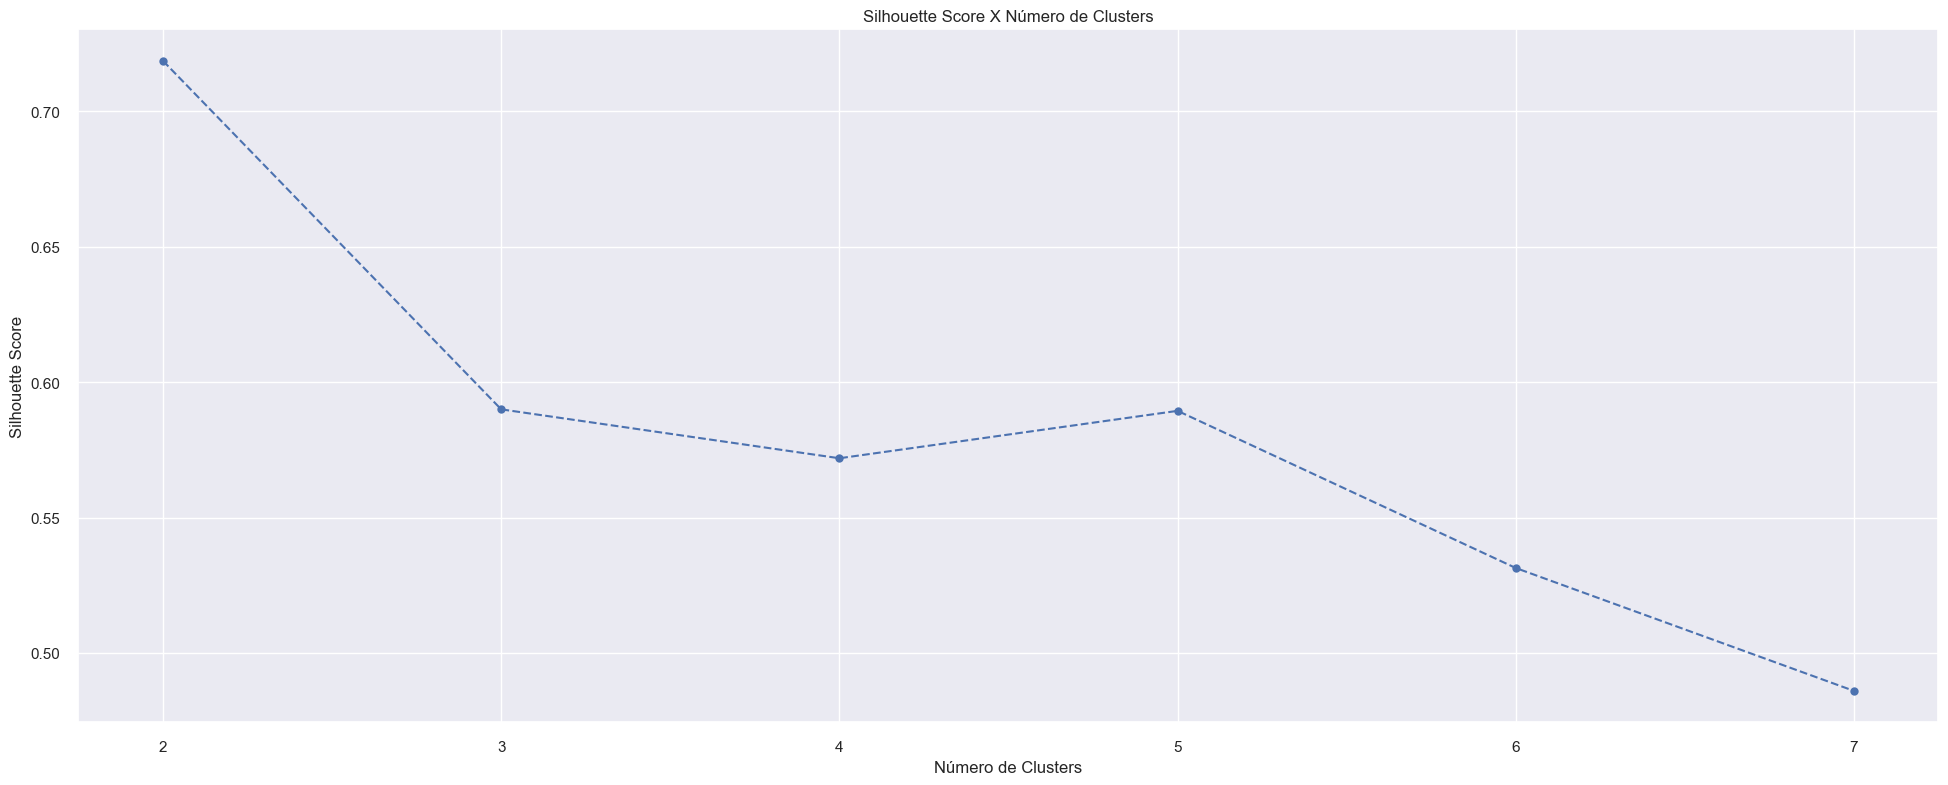

In [66]:
kmeans_list = list()

for k in clusters_feature:

    # Definição do Modelo
    kmeans_model = cluster.KMeans(n_clusters=k)

    # Treino do Modelo
    kmeans_model.fit(df_treino)

    # Predição do Modelo
    labels = kmeans_model.predict(df_treino)

    # Performance do Modelo
    sil_score = metrics.silhouette_score(df_treino, labels, metric='euclidean')
    
    # Armazenar silhouette score
    kmeans_list.append(sil_score)
    
# Plotagem do Gráfico
plt.plot(clusters_feature, kmeans_list, linestyle='--', marker='o', color='b');

# Nomeando os eixos
plt.xlabel('Número de Clusters');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score X Número de Clusters');

### Espaço de Embedding Trees

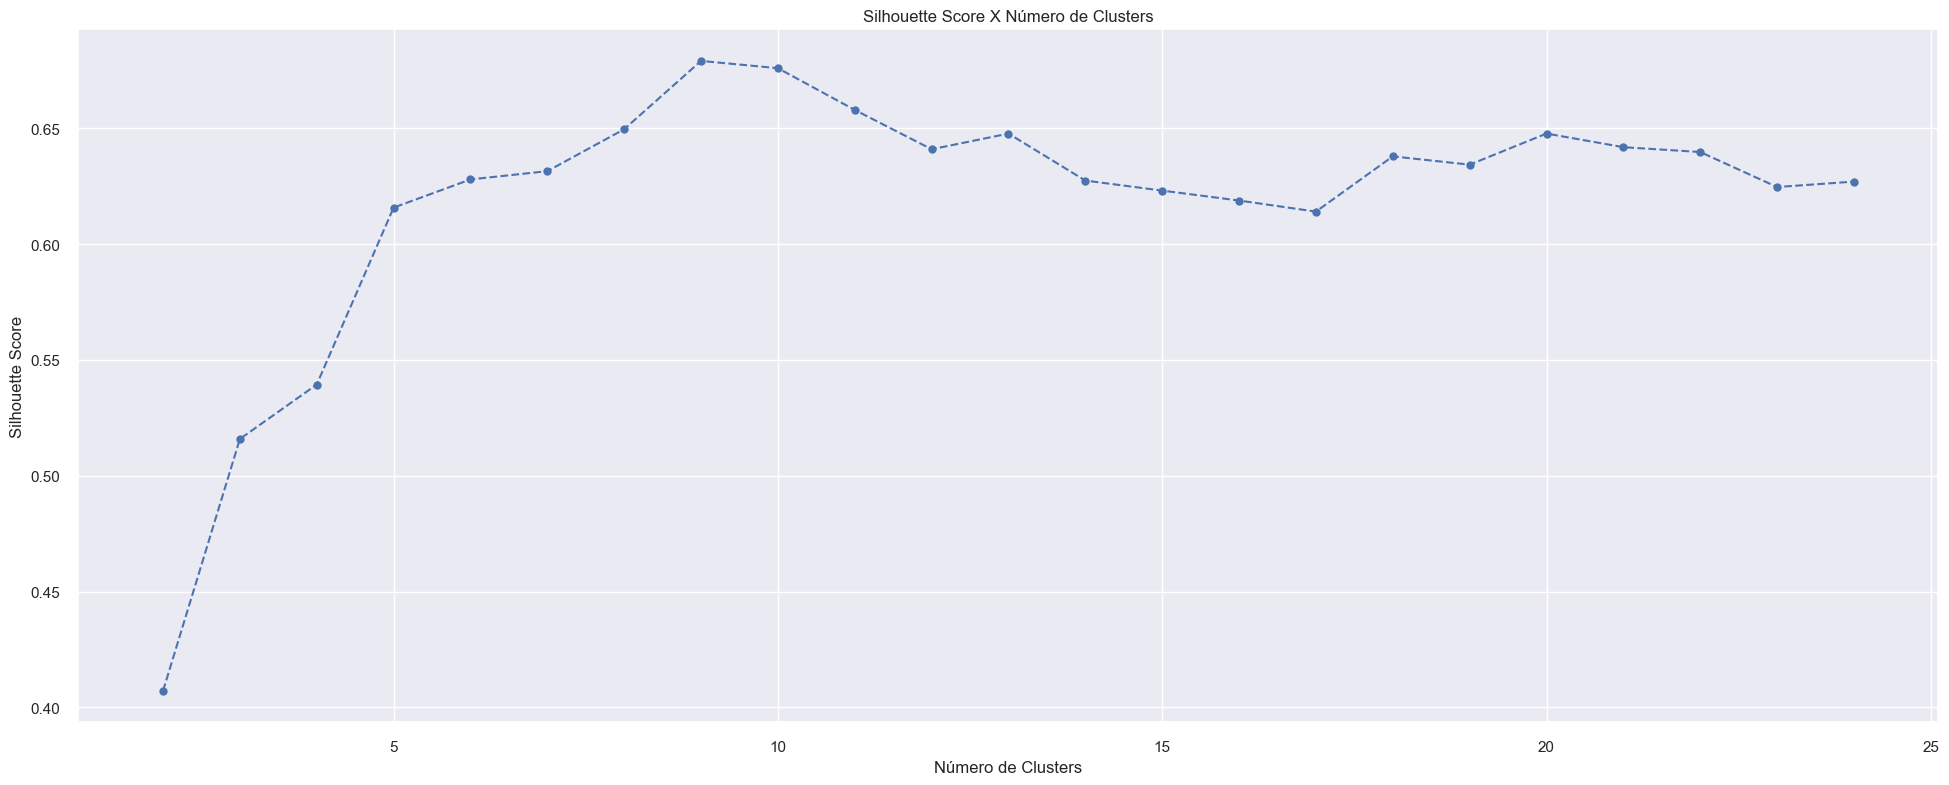

In [67]:
kmeans_list_embeeding = list()

clusters = np.arange(2,25, 1)

for k in clusters:

    # Definição do Modelo
    kmeans_model = cluster.KMeans(n_clusters=k)

    # Treino do Modelo
    kmeans_model.fit(df_tree)

    # Predição do Modelo
    labels = kmeans_model.predict(df_tree)

    # Performance do Modelo
    sil_score = metrics.silhouette_score(df_tree, labels, metric='euclidean')
    
    # Armazenar silhouette score
    kmeans_list_embeeding.append(sil_score)
    
# Plotagem do Gráfico
plt.plot(clusters, kmeans_list_embeeding, linestyle='--', marker='o', color='b');

# Nomeando os eixos
plt.xlabel('Número de Clusters');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score X Número de Clusters');

## 7.2 - Gaussian Mixture Model (GMM)

### Espaço de Features

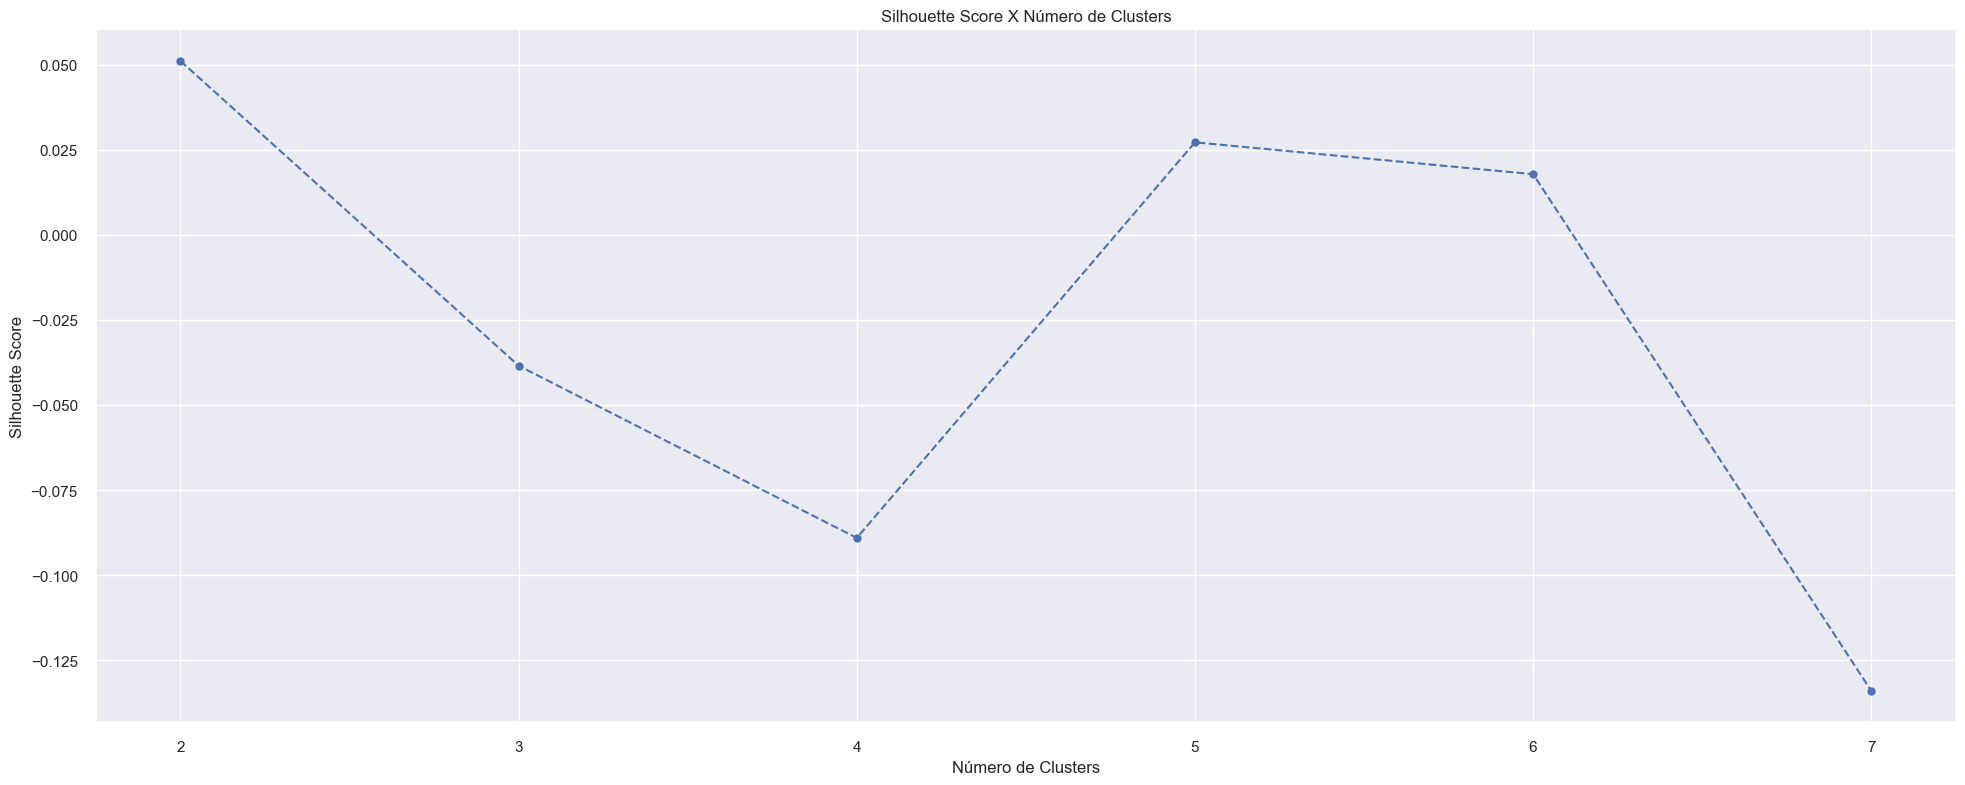

In [68]:
# Lista vazia para armazenar os valores da silhouette
gmm_list = list()


for k in clusters_feature:
    # Definição do Modelo
    gmm_model = mixture.GaussianMixture(n_components=k) 

    # Treino do Modelo
    gmm_model.fit(df_treino)

    # Predição do Modelo
    labels = gmm_model.predict(df_treino)

    # Performance do Modelo
    sil_score = metrics.silhouette_score(df_treino, labels, metric='euclidean')
    
    # Armazenamento do score
    gmm_list.append(sil_score)

# PLotagem do Gráfico
plt.plot(clusters_feature, gmm_list, linestyle='--', marker='o', color='b');

# Reajuste do gráfico
plt.xlabel('Número de Clusters');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score X Número de Clusters');

### Espaço de Embeeding - Trees

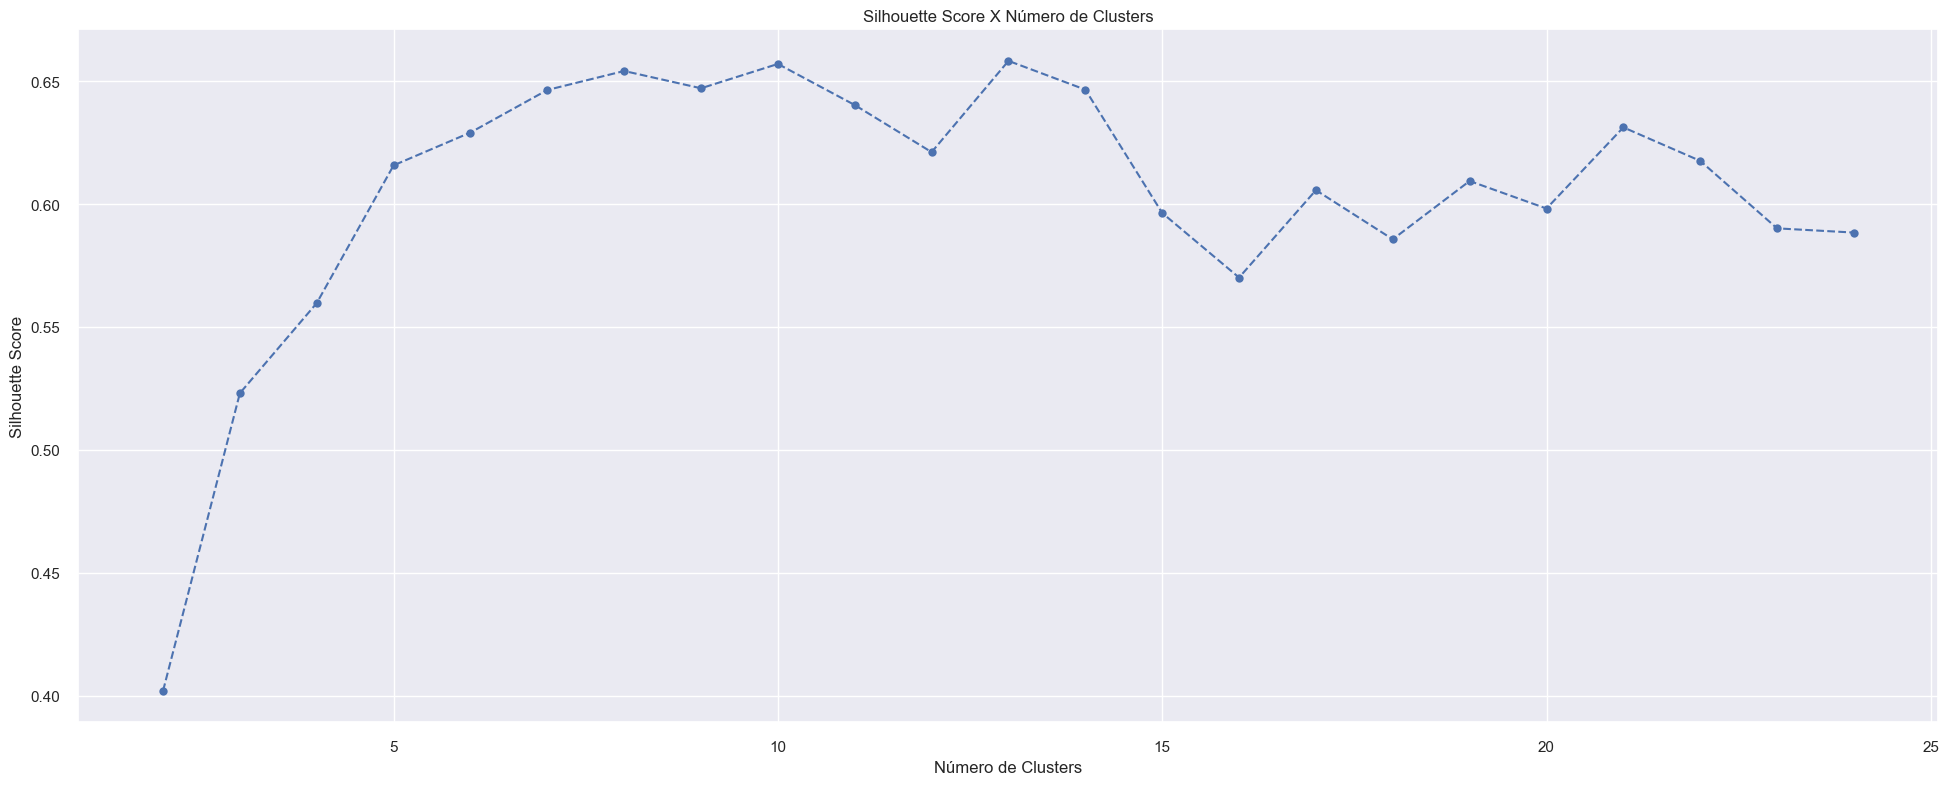

In [69]:
# Lista vazia para armazenar os valores da silhouette
gmm_list_embeeding = list()

clusters = np.arange(2,25, 1)


for k in clusters:
    # Definição do Modelo
    gmm_model = mixture.GaussianMixture(n_components=k) 

    # Treino do Modelo
    gmm_model.fit(df_tree)

    # Predição do Modelo
    labels = gmm_model.predict(df_tree)

    # Performance do Modelo
    sil_score = metrics.silhouette_score(df_tree, labels, metric='euclidean')
    
    # Armazenamento do score
    gmm_list_embeeding.append(sil_score)

# PLotagem do Gráfico
plt.plot(clusters, gmm_list_embeeding, linestyle='--', marker='o', color='b');

# Reajuste do gráfico
plt.xlabel('Número de Clusters');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score X Número de Clusters');

## 7.3 - Hierarchical Clustering 

### Espaço de Feature

In [70]:
# Definição do Modelo e treino.
#hierarchical_cluster_model = hierarchy.linkage(df_treino, 'ward')

# Plotagem do dendrograma
#dendograma = hierarchy.dendrogram(hierarchical_cluster_model, leaf_rotation=90, leaf_font_size=8)

# Configuração do tamanho
#plt.figure(figsize=(25,10))

# Exibição do Dendograma
#dendograma
#plt.show();

In [71]:
# Plotagem do dendrograma
#dendograma = hierarchy.dendrogram(hierarchical_cluster_model, 
 #                                         truncate_mode='lastp', 
  #                                        leaf_rotation=90, 
   #                                      leaf_font_size=8,
    #                                      show_contracted=True);

# Configuração do tamanho
#plt.figure(figsize=(25,10));

# Exibição do Dendograma
#dendograma;
#plt.show();

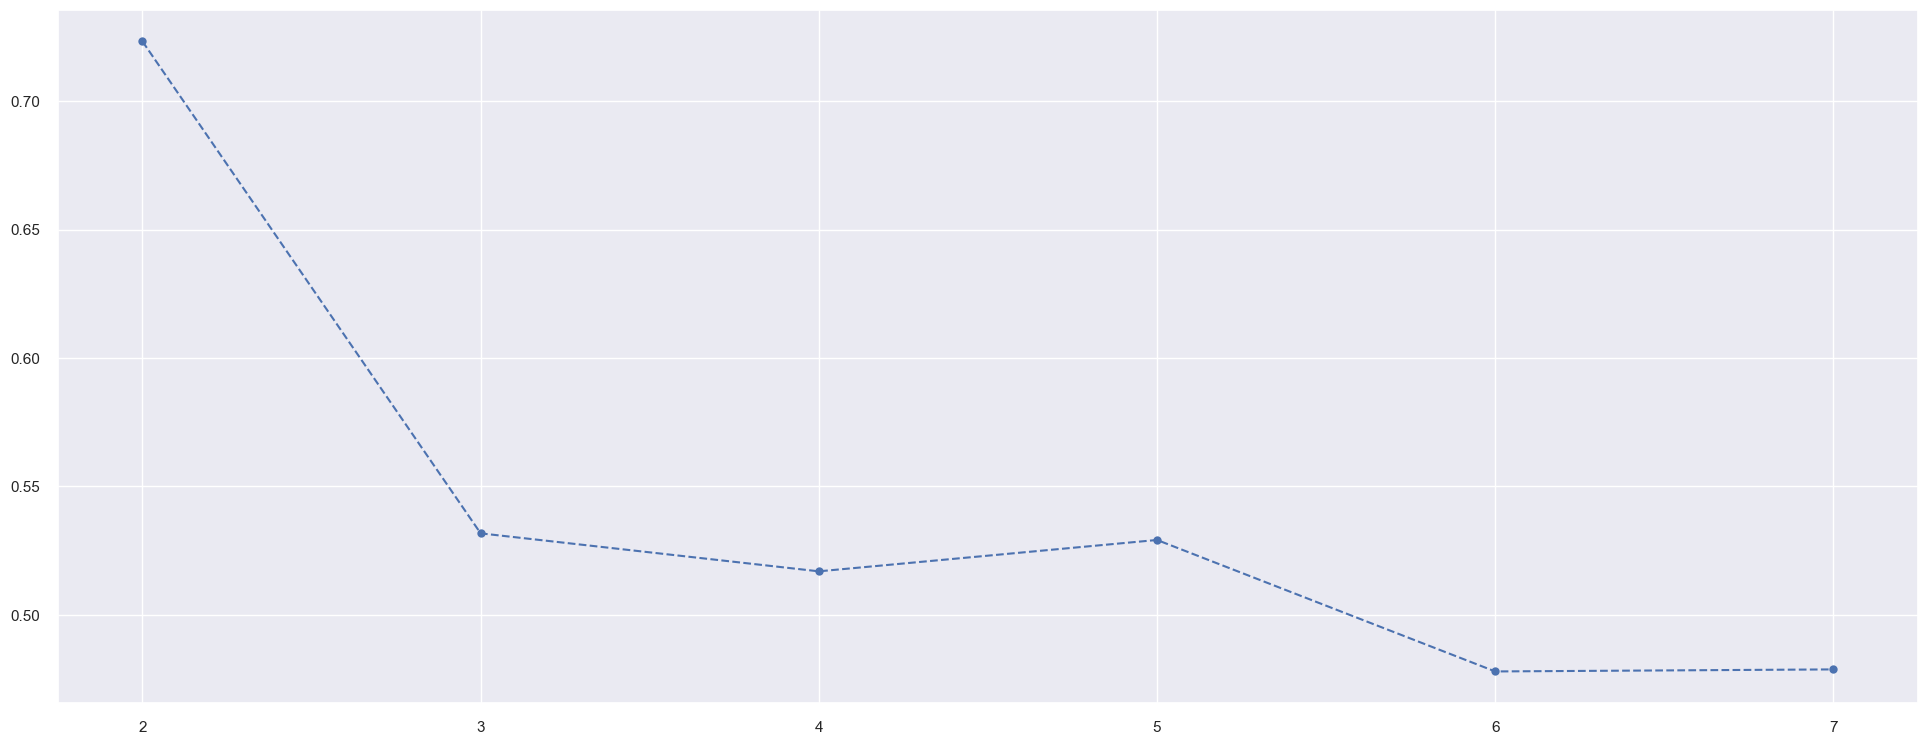

In [72]:
# Lista Vazia para armazenar os scores
hierarchical_list = list()

for k in clusters_feature:
    # Definição do Modelo e treino
    hierarchical_cluster_model = hierarchy.linkage(df_treino, 'ward')

    # Predição do Modelo
    labels = hierarchy.fcluster(hierarchical_cluster_model, k, criterion='maxclust')

    # Analise da Silhouette 
    sil_score = metrics.silhouette_score(df_treino, labels, metric='euclidean')
    
    # Armazenamento do silhouette score
    hierarchical_list.append(sil_score)

# Plotagem dos scores
plt.plot(clusters_feature, hierarchical_list, linestyle='--', marker='o', color='b');

### Espaço de Embeeding

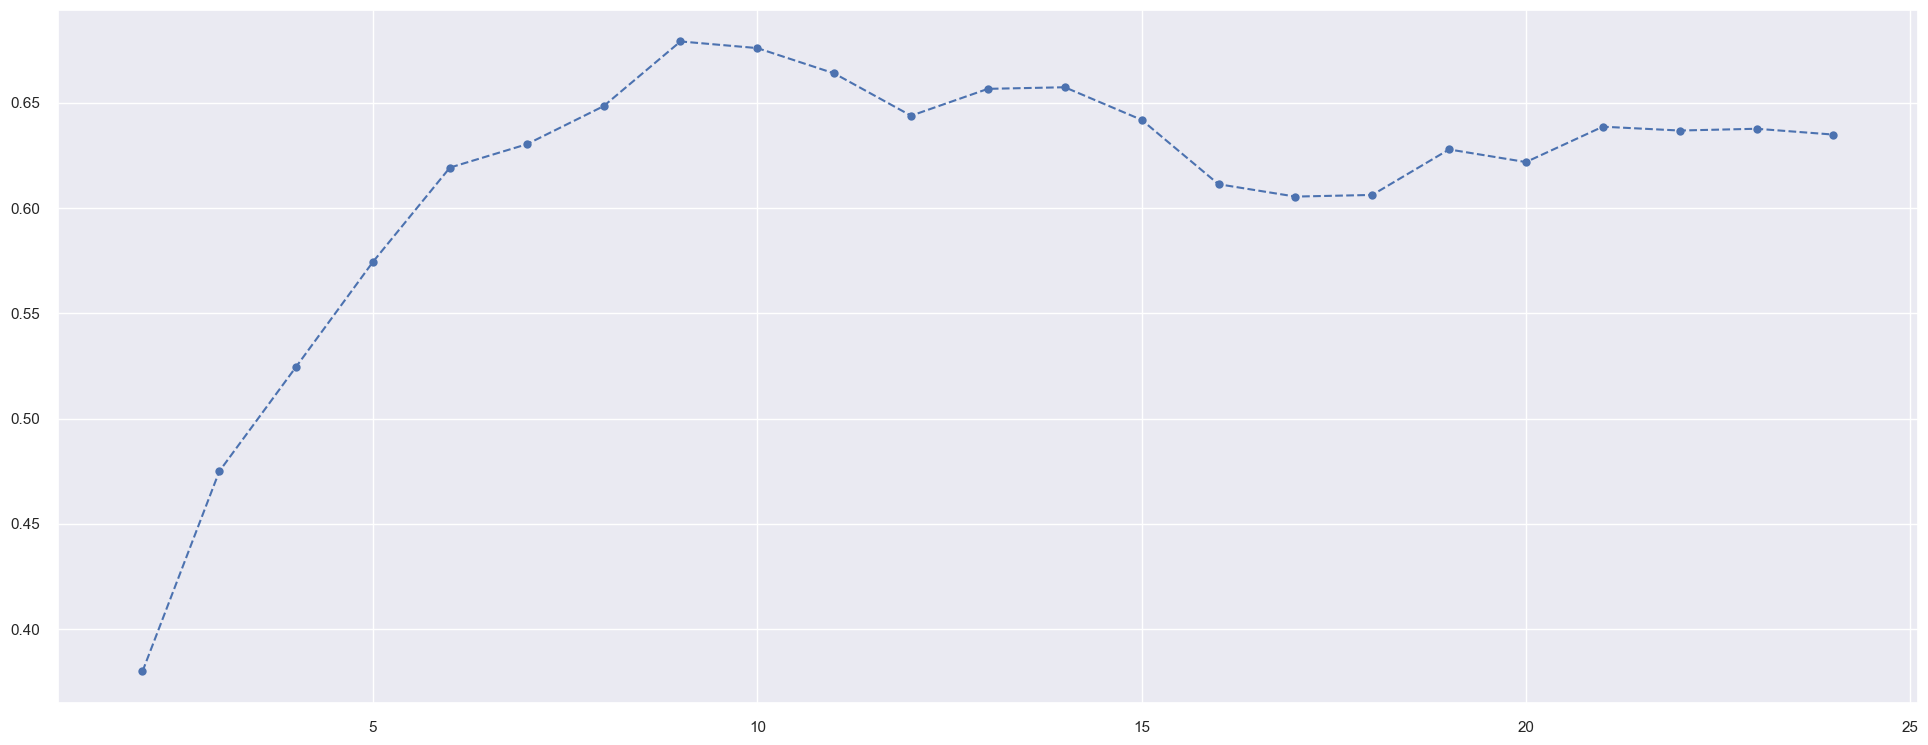

In [73]:
# Lista Vazia para armazenar os scores
hierarchical_list_embeeding = list()

clusters = np.arange(2,25,1)

for k in clusters:
    # Definição do Modelo e treino
    hierarchical_cluster_model = hierarchy.linkage(df_tree, 'ward')

    # Predição do Modelo
    labels = hierarchy.fcluster(hierarchical_cluster_model, k, criterion='maxclust')

    # Analise da Silhouette 
    sil_score = metrics.silhouette_score(df_tree, labels, metric='euclidean')
    
    # Armazenamento do silhouette score
    hierarchical_list_embeeding.append(sil_score)

# Plotagem dos scores
plt.plot(clusters, hierarchical_list_embeeding, linestyle='--', marker='o', color='b');

## 7.4 - DBSCAN

In [74]:
df_treino.shape

(2773, 5)

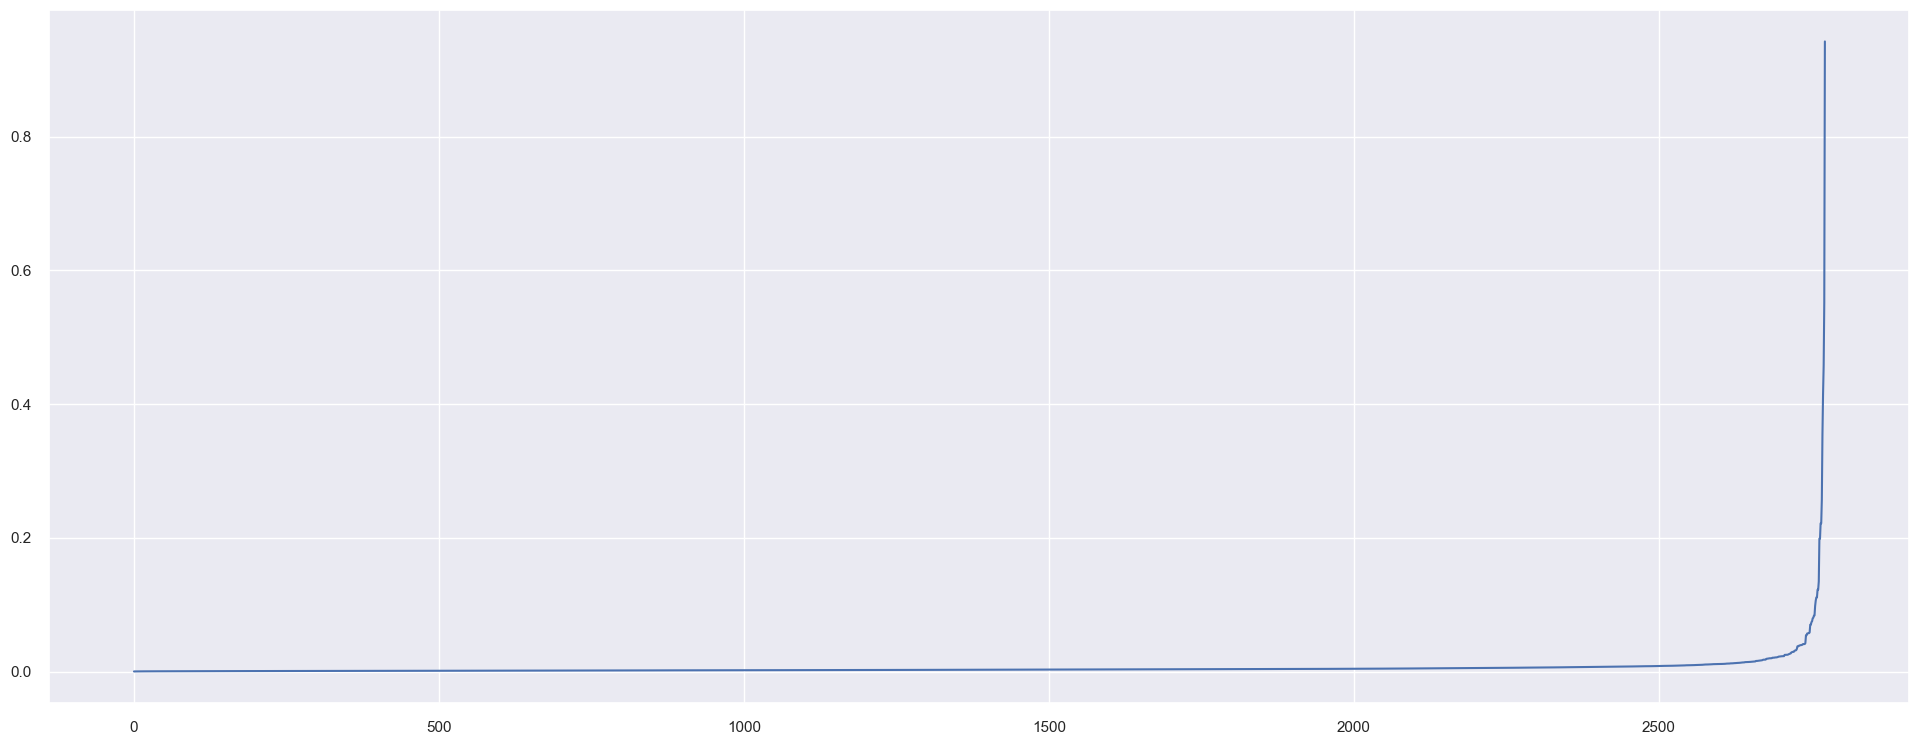

In [75]:
# Quantidade mínima de vizinho em um vizinhança
min_samples = 5

# Determinação dos Parâmetros
vizinhanças = neighbors.NearestNeighbors(n_neighbors=min_samples).fit(df_treino)

# Obtenção das distâncias
distances, indices = vizinhanças.kneighbors(df_treino)

# Ordenação
distances = np.sort(distances, axis=0)

# Extração dos dados necessários
distances = distances[ : , 1]

# Plotagem dos Dados
plt.plot(distances);

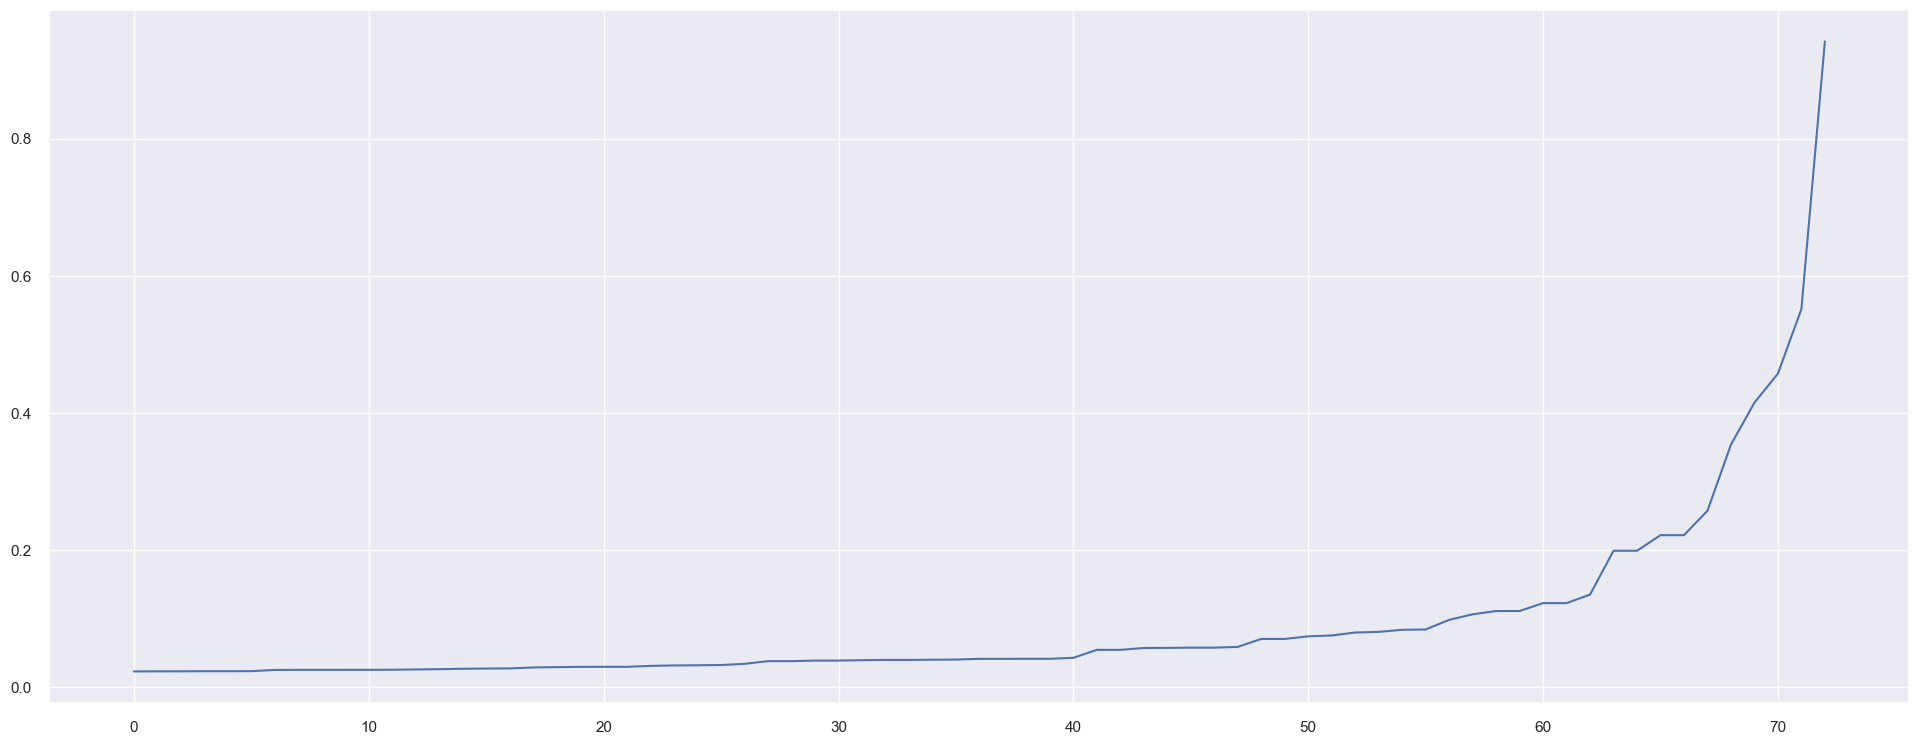

In [76]:
plt.plot(distances[2700: ]);

In [77]:
# Ótimos Parâmetros
# eps=0.5 e min_samples=3
# eps=0.2 e min_samples=3

# Parâmetros
eps=0.1
min_samples=3

# Definição do Modelo
dbscan_model = cluster.DBSCAN(eps=eps, min_samples=min_samples)

# Treino e Predição do Modelo
labels = dbscan_model.fit_predict(df_treino)

# Análise da Silhouette Score
sil_score = metrics.silhouette_score(df_treino, labels, metric='euclidean')

# Exibição
print('Silhouette Score: {}'.format(sil_score))
print('Número de Clusteres: {}'.format(unique(labels).tolist()))

Silhouette Score: 0.5105298538648011
Número de Clusteres: [-1, 0, 1]


In [78]:
dbscan_list = [0.51, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000]

## 7.5 - Results

### Espaço de Features

In [79]:
# Organzação dos resultados
df_results = pd.DataFrame({'kMeans Model' : kmeans_list, 
                           'GMM Model' : gmm_list, 
                           'Hierarchical Model': hierarchical_list, 
                           'DBSCAN Model': dbscan_list}).T

# Renomear as colunas de acordo com os clusters propostos
df_results.columns = clusters_feature

# Destacamento dos melhores resultados em cada modelo
df_results = df_results.style.highlight_max(color='yellow', axis=1)

# Exibição
df_results

,2,3,4,5,6,7
kMeans Model,0.718584,0.589954,0.571900,0.589398,0.531390,0.486024
GMM Model,0.051086,-0.038465,-0.089072,0.027165,0.017799,-0.134003
Hierarchical Model,0.723230,0.531763,0.516980,0.529187,0.478013,0.478808
DBSCAN Model,0.510000,0.000000,0.000000,0.000000,0.000000,0.000000


### Espaço de Embeeding - Trees

In [80]:
# Organzação dos resultados
df_results = pd.DataFrame({'kMeans Model' : kmeans_list_embeeding, 
                           'GMM Model' : gmm_list_embeeding, 
                           'Hierarchical Model': hierarchical_list_embeeding}).T

# Renomear as colunas de acordo com os clusters propostos
df_results.columns = clusters

# Destacamento dos melhores resultados em cada modelo
df_results = df_results.style.highlight_max(color='yellow', axis=1)

# Exibição
df_results

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
kMeans Model,0.407158,0.515906,0.539399,0.615768,0.627944,0.631511,0.649614,0.679109,0.675951,0.657941,0.640960,0.647725,0.627447,0.623120,0.618825,0.614047,0.637894,0.634313,0.647736,0.641868,0.639769,0.624659,0.626998
GMM Model,0.402007,0.523099,0.559743,0.615768,0.629124,0.646421,0.654146,0.647113,0.657016,0.640296,0.621141,0.658256,0.646558,0.596396,0.570126,0.605670,0.585686,0.609398,0.598205,0.631213,0.617589,0.590140,0.588427
Hierarchical Model,0.379941,0.475000,0.524659,0.574493,0.619201,0.630286,0.648389,0.679109,0.675951,0.663936,0.643838,0.656602,0.657356,0.641867,0.611310,0.605439,0.606219,0.627827,0.621826,0.638627,0.636803,0.637643,0.634883


# 8.0 - Treinamento do Modelo

A partir da análise da silhouette, vimos que os dois modelos que tiveram o melhor desempenho foram o KMeans e o Hierarchical. Assim, para finalizar essa parte, vamos realizar um cross-validation com esses dois modelos e determinar qual desses modelos realiza a melhor clusterização.

## 8.1 - K-means CrossValidation

In [81]:
# Modelo definido
k=9
kmeans = cluster.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# Treino do Modelo
kmeans.fit(df_tree)

# clustering
labels_kmeans = kmeans.labels_

# WSS Score
print(f'WSS Score: {kmeans.inertia_}.')

# Silhouette Score
print(f'Silhouette Score: {metrics.silhouette_score(df_tree, labels_kmeans)}')

WSS Score: 13573.3193359375.
Silhouette Score: 0.637943685054779


## 8.2 - Hierarchical CrossValidation

In [82]:
# Definição do Modelo e Treino
k = 9
hierarchical_cluster_model = hierarchy.linkage(df_tree, 'ward')

# Predição do Modelo
labels_hierarchical = hierarchy.fcluster(hierarchical_cluster_model, k, criterion='maxclust')

# Silhouette Score
print('Silhouette Score: {}'.format(metrics.silhouette_score(df_tree, labels_hierarchical, metric='euclidean')))

Silhouette Score: 0.6791088581085205


## 8.3 - GMM CrossValidation

In [83]:
# Definição do Modelo 
k=9
gmm_model = mixture.GaussianMixture(n_components=k) 

# Treino do Modelo
gmm_model.fit(df_tree)

# Predição do Modelo
labels_gmm = gmm_model.predict(df_tree)

# Performance do Modelo
print('Silhouette Score: {}'.format(metrics.silhouette_score(df_tree, labels_gmm, metric='euclidean')))

Silhouette Score: 0.6295613646507263


# 9.0 - Cluster Analysis

In [84]:
df9 = df_tree.copy()

## 9.1 - Inspeção por Visualização - Kmeans

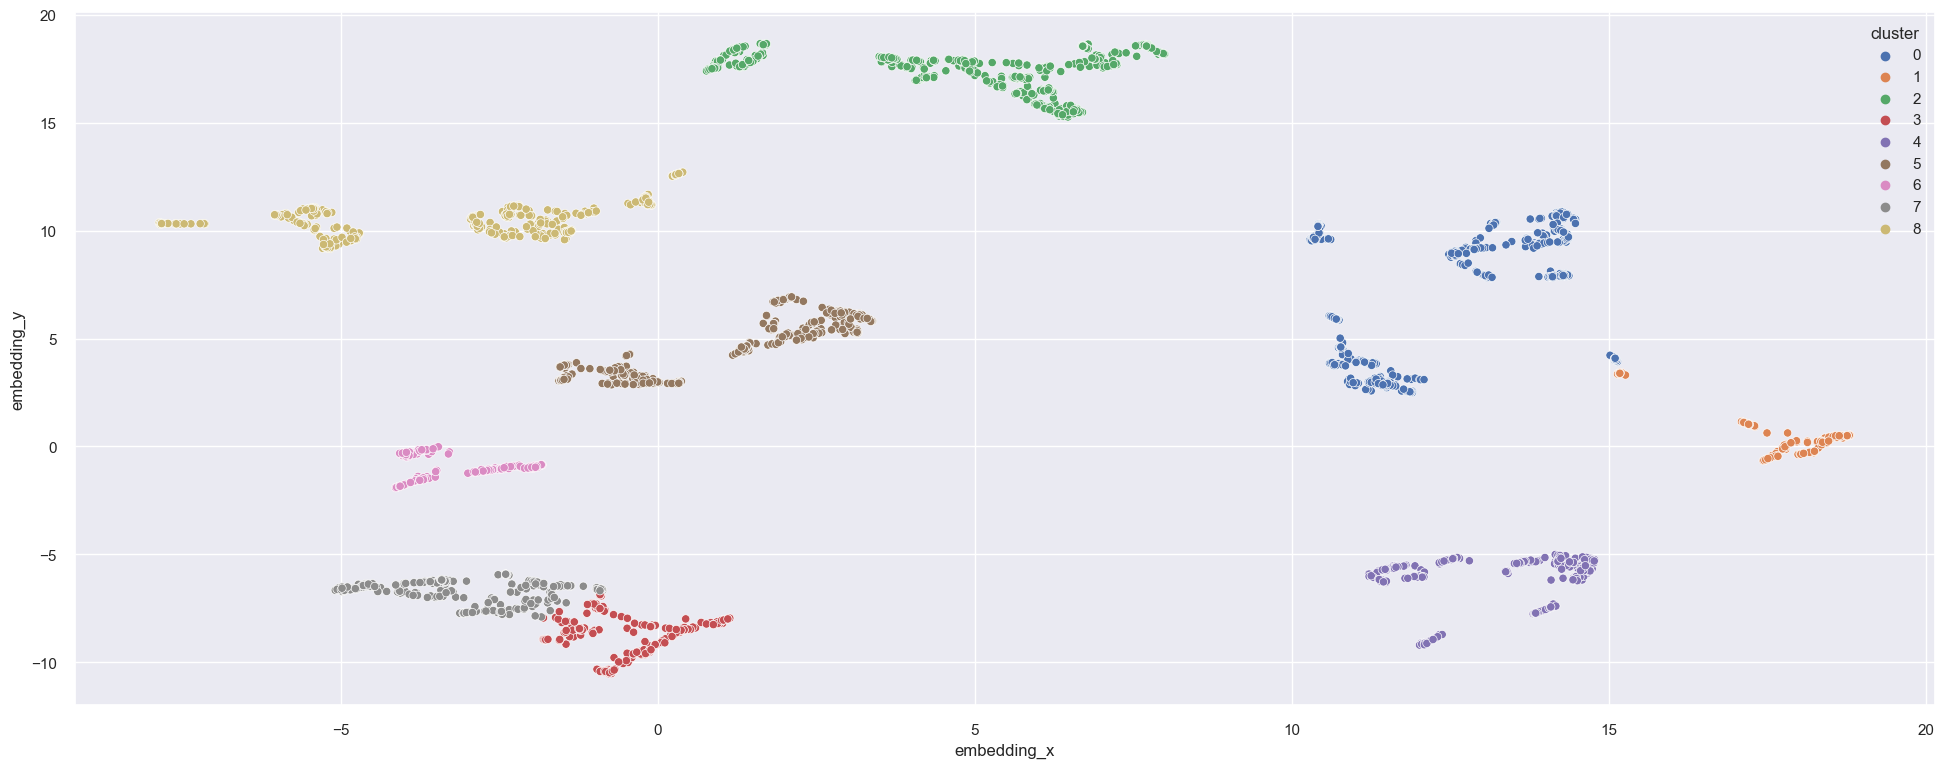

In [85]:
# Rotulando cada cliente de acordo o o seu cluster
df9['cluster'] = labels_kmeans

sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette='deep', data=df9);

## 9.2 - Inspeção por Visualização - Hierarchical

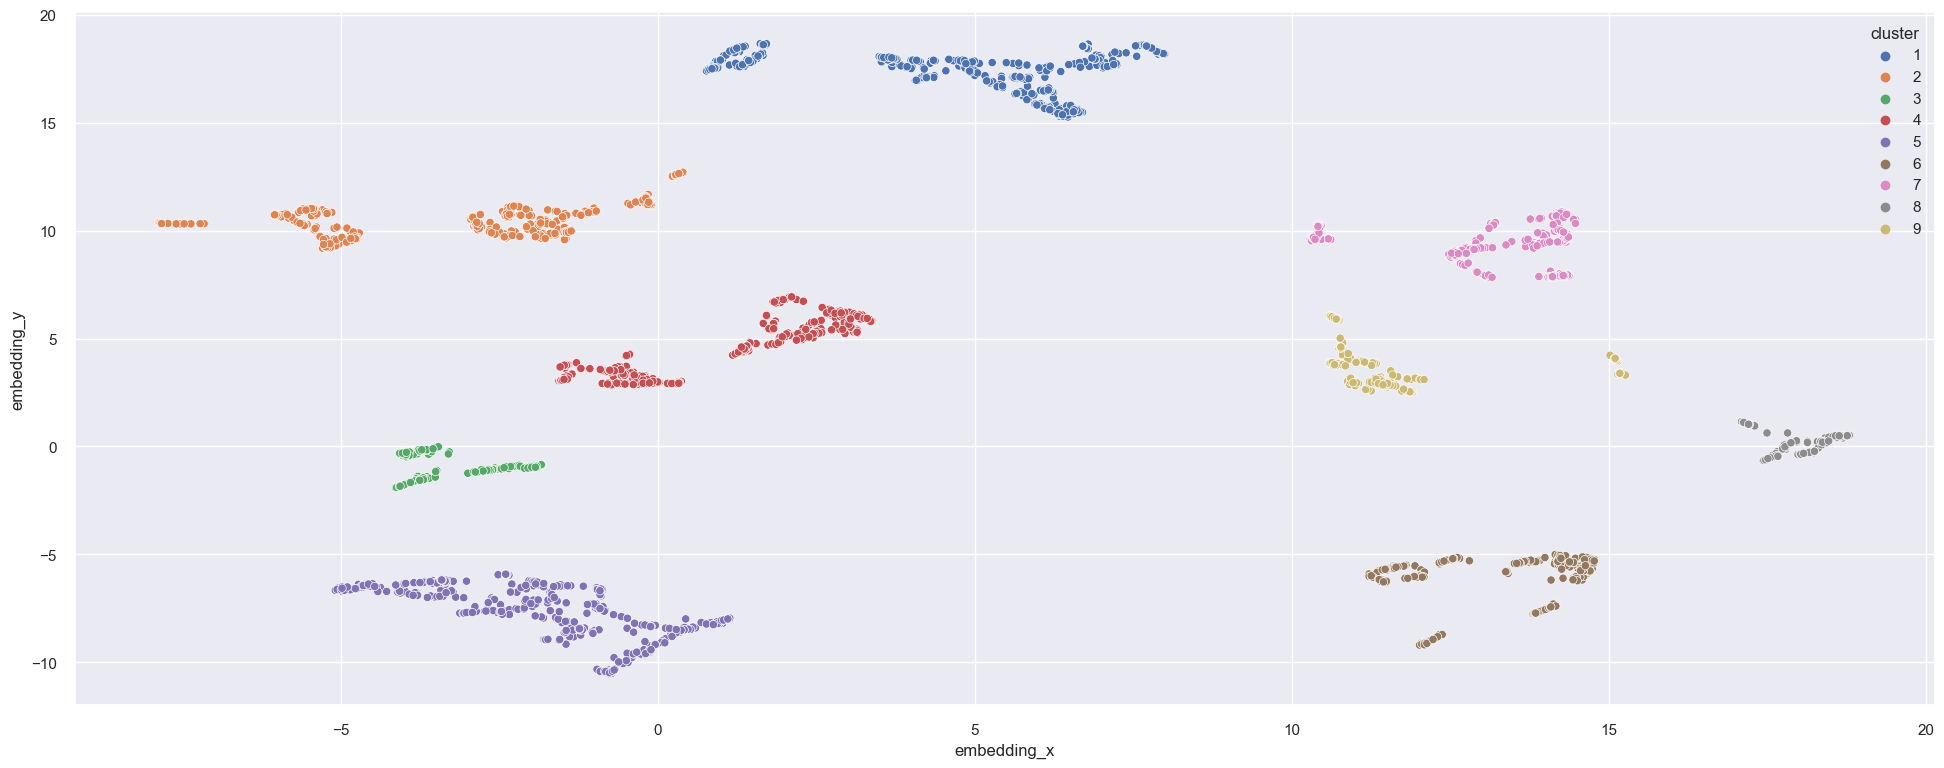

In [86]:
# Rotulando cada cliente de acordo o o seu cluster
df9['cluster'] = labels_hierarchical

sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette='deep', data=df9);

## 9.3 - Inspeção por Visualização - GMM

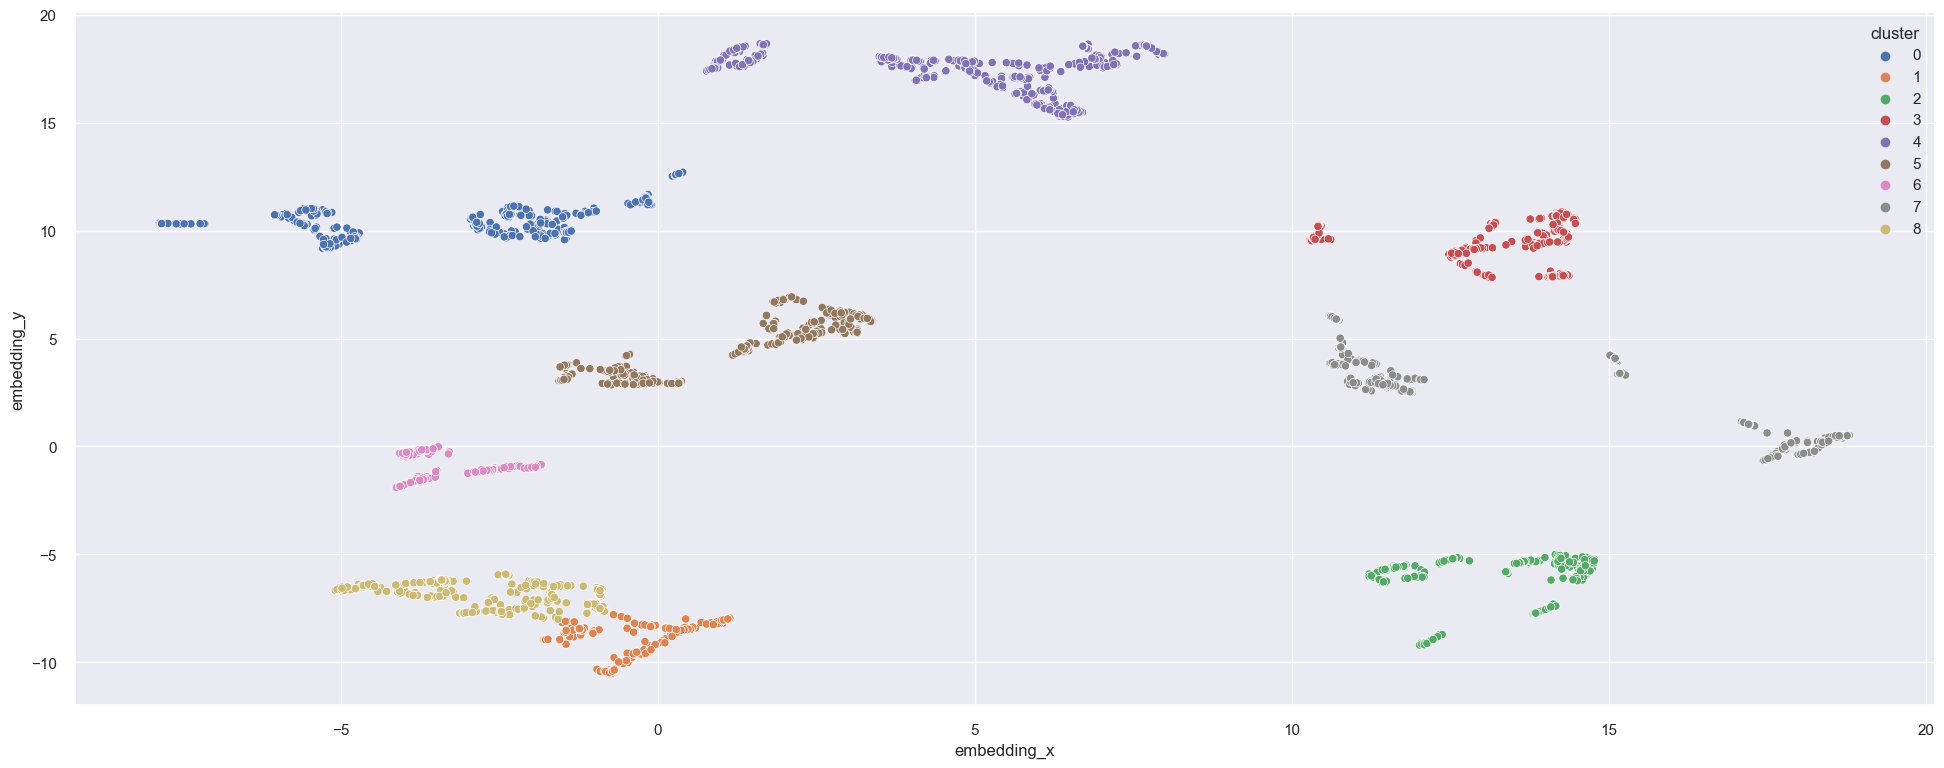

In [87]:
# Rotulando cada cliente de acordo o o seu cluster
df9['cluster'] = labels_gmm

sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette='deep', data=df9);

## 9.4 - Perfil dos Cluster

In [253]:
# rotular cada cliente de acordo com o seu cluster
df4['cluster'] = labels_hierarchical

# quantidade de clientes por cluster
df_cluster = df4[['customer_id', 'cluster']].groupby('cluster').count().reset_index().rename(columns={'customer_id':'number_customers'})

# Media de Faturamento por Cluster
df_mean_gross_revenue = df4[['faturamento', 
                                'cluster']].groupby('cluster').mean().reset_index().rename(columns= {'faturamento':'media_faturamento'})

# Media de Recência de Compras
df_mean_recencia = df4[['recencia_dias', 
                             'cluster']].groupby('cluster').mean().reset_index().rename(columns={'recencia_dias':'media_recencia'})

# Media de Recências
df_mean_produtos_comprados = df4[['qtde_tipos_produtos_comprados', 
                              'cluster']].groupby('cluster').mean().reset_index().rename(columns={'qtde_tipos_produtos_comprados':'media_produtos_comprados'})

# Media das compras
df_mean_frequency = df4[['frequencia_compra', 'cluster']].groupby('cluster').mean().reset_index()

# Média de DEvoluções
df_mean_returns = df4[['qtde_devolucoes', 'cluster']].groupby('cluster').mean().reset_index()


# Junção de todos os dados em uma única tabela.
df_aux = pd.merge(df_cluster, df_mean_gross_revenue, how='inner', on='cluster')
df_aux = pd.merge(df_aux, df_mean_recencia, how='inner', on='cluster')
df_aux = pd.merge(df_aux, df_mean_produtos_comprados, how='inner', on='cluster')
df_aux = pd.merge(df_aux, df_mean_frequency, how='inner', on='cluster')
df_aux = pd.merge(df_aux, df_mean_returns, how='inner', on='cluster')

tabela_final = df_aux.copy()
# Criação da coluna que nos dá o percentual de clientes em cada cluster.
tabela_final['number_customer_percentual'] = round((tabela_final['number_customers']/tabela_final['number_customers'].sum())*100, 2)

In [261]:
tabela_final = tabela_final.sort_values('media_faturamento', ascending=False)

## Relatório Final

In [262]:
tabela_final

,cluster,number_customers,media_faturamento,media_recencia,media_produtos_comprados,frequencia_compra,qtde_devolucoes,number_customer_percentual
4,5,465,8872.955419,21.200000,426.064516,0.088730,145.152688,16.77
2,3,161,3130.104472,35.391304,171.993789,0.057160,23.142857,5.81
1,2,418,2686.195909,49.440191,98.734450,0.034494,15.148325,15.07
3,4,348,2394.036178,45.491379,125.359195,0.037027,26.951149,12.55
0,1,467,1254.598865,58.685225,57.603854,0.032776,7.736617,16.84
8,9,205,1011.859415,82.541463,26.829268,0.038814,14.287805,7.39
6,7,288,922.392326,72.822917,37.305556,0.039849,10.552083,10.39
5,6,300,644.538000,46.506667,14.430000,0.048248,0.980000,10.82
7,8,121,422.673058,213.041322,14.247934,0.089871,1.438017,4.36


# 10.0 - Análise Exploratória de Dados

## 10.1 - Mapa Mental de Hipóteses

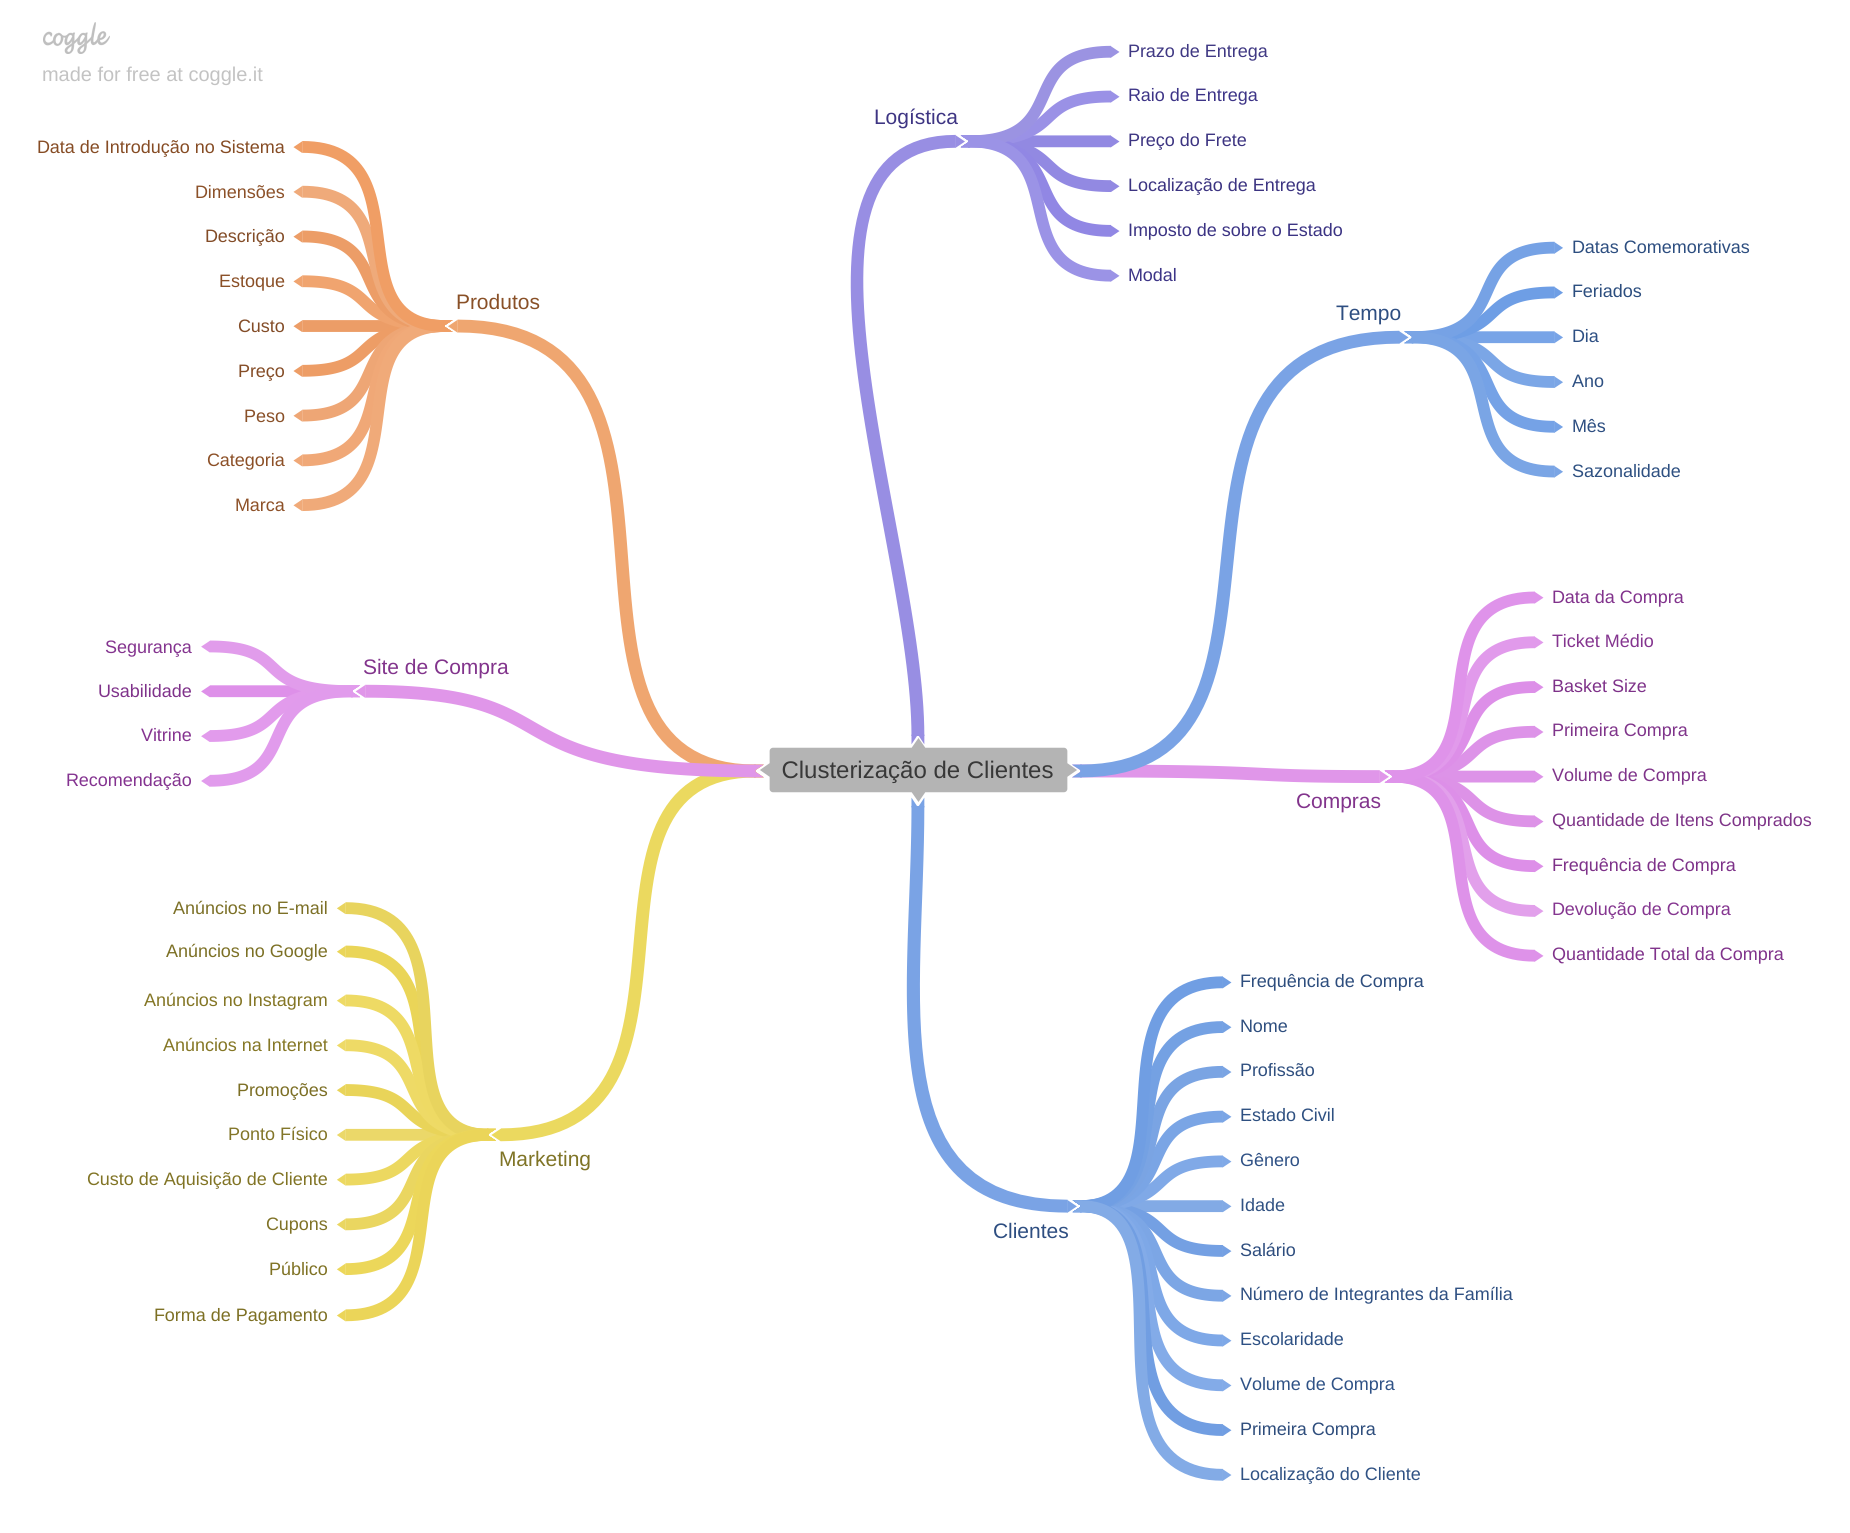

In [260]:
Image('mindmap.png')

## 10.2 - Hipóteses de Negócios

In [263]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 11.0 - Deploy do Modelo em Produção